# Import des librairies

In [1]:
import os
import subprocess, re, uuid, pwd
from keras import backend as K 
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.models import Sequential # Pour construire un réseau de neurones
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split # Pour répartir les données

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import time


Init Plugin
Init Graph Optimizer
Init Kernel


In [9]:
pretrained_model1 = VGG16(weights='imagenet', include_top=False) 
pretrained_model2 = VGG19(weights='imagenet', include_top=False) 
pretrained_model3 = ResNet50(weights='imagenet', include_top=False) 
pretrained_model4 = Xception(weights='imagenet', include_top=False) 

print(len(pretrained_model1.layers))
print(len(pretrained_model2.layers))
print(len(pretrained_model3.layers))
print(len(pretrained_model4.layers))



19
22
175
132


In [2]:
try:
    # identifiant Windows
    ide = re.findall(r'[A-Z0-9-]+-[A-Z0-9-]+',str(subprocess.check_output('wmic csproduct get uuid').strip()))[0]
    
except OSError:
    try:
        # identifiant Linux
        ide = pwd.getpwuid( os.getuid() ).pw_name
    except OSError:
        # identifiant Mac OS
        ide = hex(uuid.getnode())
        
local_var = pd.read_csv('path.csv',index_col=0)

if ide in local_var.index:
    username = local_var.loc[ide,'name']
    path_dataset = local_var.loc[ide,'path_dataset']
    path_analysis = local_var.loc[ide,'path_analysis']
    path_data_prep = local_var.loc[ide,'path_data_prep']
    path_models = local_var.loc[ide,'path_models']
    print(f'  Username: {username}\n'
         +f'  Dataset directory: {path_dataset}\n'
         +f'  Saved analysis: {path_analysis}\n'
         +f'  Data preprocessed directory: {path_data_prep}\n'
         +f'  Models directory: {path_models}')
else:
    print('Computer not recognized :\n'
         f'  Please enter your computer_id {ide} and the associated parameters in \path.csv')

  Username: Emilien
  Dataset directory: /Users/emilienbonhomme/Desktop/DataScientest - Projet Blood Cell/PBC_dataset_normal_DIB/
  Saved analysis: nan
  Data preprocessed directory: /Users/emilienbonhomme/Desktop/DataScientest - Projet Blood Cell/Datasets/
  Models directory: /Users/emilienbonhomme/Desktop/DataScientest - Projet Blood Cell/Models/


# Fonction de chargement du dataset (.parquet)

In [3]:
def load_dataset(dataset_name):
    start = time.time()
    data_df = pd.read_parquet(path_data_prep + dataset_name)
    end = time.time()
    load_time = round(end - start,3)
    
    return data_df, load_time

# DEEP LEARNING

## 1. Modèle From Scratch

In [4]:
def my_CNN (dataset, size_img,img_filter):

    #---------------------------------------------PREPROCESSING---------------------------------------------#

    K.clear_session()                               # Libération de la mémoire
    start = time.time()                             # Lancement du timer
    dim = 0                                         # initialisation de la variable dim (dimension de l'image)
                                                    # Si l'image est en rgb alors "dim = 3"
        
    if (img_filter == "rgb" or img_filter == "hsv" or img_filter == "lab" or img_filter == "kmeans1" 
        or img_filter == "kmeans2" or img_filter == "kmeansXYRGB" or img_filter == "threshold_color" 
        or img_filter == "equalizer") :    
        dim = 3
    
    elif (img_filter=="gray" or img_filter=="canny" or img_filter=="otsu" or img_filter=="threshold_color_g" or 
          img_filter=="otsu_canny" ) :
        dim = 1
        
    else:
        print("img_filter = 'rgb','gray, 'hsv', 'lab', 'canny', 'otsu', 'kmeans1', 'kmeans2','kmeansXYRGB', 'threshold_color', 
               'threshold_color_g','otsu_canny', 'equalizer'")
    
              
    # On separe les features des labels
    X = dataset.drop(["type"], axis = 1)
    y = dataset["type"]
              
    # Encoder la varible y
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    # On split le dataset general en set d'entrainement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)
    
    # On split le dataset d'entrainement en set d'entrainement et de validation
    # La distribution finale = train :60%, valid : 20%, test:20%
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state = 123)
        
    # conversion des dataframes en array et on reforme les images dans sa dimension initiale (60X60X3 ou 60X60X1)
    X_train = np.array(X_train)
    X_train = X_train.reshape(-1, size_img,size_img,dim).astype(int)
    
    X_valid = np.array(X_valid)
    X_valid = X_valid.reshape(-1, size_img,size_img,dim).astype(int)

    X_test = np.array(X_test)
    X_test = X_test.reshape(-1, size_img,size_img,dim).astype(int)

    # On normalise les données des 3 sets
    X_train = X_train / 255
    X_valid = X_valid / 255
    X_test = X_test / 255

    # On binarise les labels
    y_train = np_utils.to_categorical(y_train)
    y_valid = np_utils.to_categorical(y_valid)
    y_test = np_utils.to_categorical(y_test)
    
    # On recupère le nombre de classe 
    num_classes = y_train.shape[1]
    
    #---------------------------------------------CALLBACKS---------------------------------------------#
    # Stoppe le processus lorsque "val_loss" ne diminue pas de 1% sur 5 epochs
    early_stopping = EarlyStopping(
                                patience=5, # Attendre 5 epochs avant application
                                min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
                                # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'min',
                                monitor='val_loss')
    
    # Réduit le taux d'apprentissage lorsque "val_loss" a arrêté de diminuer sur 3 epochs,
    # on reduit le learning rate d'un facteur 0.1
    reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3,
                                    min_delta= 0.01,
                                    factor=0.1,  
                                    cooldown = 4,
                                    verbose=1)

    #-------------------------CREATION, ENTRAINEMENT ET PREDICTION DU MODELE-------------------------#
    #Construction du modèle
    model = Sequential([layers.Conv2D(128,(3,3), activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Conv2D(64,(3,3), activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Conv2D(32,(3,3), activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Conv2D(16,(3,3), activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Dropout(0.1),
                        layers.Flatten(),
                        layers.Dense(32,activation='relu'),
                        layers.Dense(num_classes, activation='softmax')
                       ])

    
    #Compilation du modèle
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
   
    # On entraine le modèle et on stocke les résultats
    # (loss et accuracy pour le train et la validation) dans history
    epochs = 30
    training_history = model.fit(X_train, y_train,
                                 validation_data = (X_valid,y_valid),
                                 epochs = epochs,
                                 callbacks = [reduce_learning_rate,
                                              early_stopping,])
    
    #Prédiction du modèle sur le dataset Test
    test_pred = model.predict(X_test)

    test_pred_class = test_pred.argmax(axis = 1)
    y_test_class = y_test.argmax(axis = 1)
    
    
    #----------------------------------------DATAVIZ et RESULTATS----------------------------------------#
    # Si le processus ne s'arrete pas, le nombre d'épochs retenu est celui choisi plus haut +1
    # Sinon, le nombre d'épochs retenu est celui de l'arrêt +2
    if early_stopping.stopped_epoch == 0:
        stop_epochs = epochs + 1
    else:
        stop_epochs = early_stopping.stopped_epoch + 2
    
    
    # Courbe de précision sur l'échantillon d'entrainement via epochs
    plt.plot(np.arange(1 , stop_epochs, 1),
             training_history.history['accuracy'],
             label = 'Training Accuracy',
             color = 'blue')

    # Courbe de précision sur l'échantillon de validation via epochs
    plt.plot(np.arange(1 ,stop_epochs, 1),
             training_history.history['val_accuracy'], 
             label = 'Validation Accuracy',
             color = 'red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Rapport de classification 
    print(classification_report(y_test_class, test_pred_class))
    
    # Matrice de confusion
    cnf_matrix = confusion_matrix(y_test_class, test_pred_class)

    plt.figure()
    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(range(0,8)))
    plt.xticks(tick_marks, range(0,8))
    plt.yticks(tick_marks, range(0,8))
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()
    
    #model.save(path_models + 'my_CNN.h5')
    
    # Arret du timer et affichage de la durée du process
    end = time.time()
    duration = end - start
    print('Durée :', round(duration,3), 'sec')

### RGB

In [5]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_rgb.parquet')

## TEST Dense 128

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Metal device set to: Apple M1


2022-01-16 16:38:16.576944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-16 16:38:16.577614: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-16 16:38:19.421770: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-16 16:38:19.458004: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-01-16 16:38:28.466808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.8058 - accuracy: 0.2853

2022-01-16 16:38:42.054796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 24s 46ms/step - loss: 1.8050 - accuracy: 0.2857 - val_loss: 1.2693 - val_accuracy: 0.5411
Epoch 2/30
321/321 [==============================] - 13s 41ms/step - loss: 1.0936 - accuracy: 0.5825 - val_loss: 0.8238 - val_accuracy: 0.6815
Epoch 3/30
321/321 [==============================] - 14s 43ms/step - loss: 0.9114 - accuracy: 0.6518 - val_loss: 0.8259 - val_accuracy: 0.6745
Epoch 4/30
321/321 [==============================] - 14s 45ms/step - loss: 0.8388 - accuracy: 0.6867 - val_loss: 0.7506 - val_accuracy: 0.7224
Epoch 5/30
321/321 [==============================] - 14s 44ms/step - loss: 0.7342 - accuracy: 0.7161 - val_loss: 0.6492 - val_accuracy: 0.7572
Epoch 6/30
321/321 [==============================] - 14s 44ms/step - loss: 0.6764 - accuracy: 0.7432 - val_loss: 0.5597 - val_accuracy: 0.7950
Epoch 7/30
321/321 [==============================] - 14s 42ms/step - loss: 0.6436 - accuracy: 0.7567 - val_loss: 0.5559 - val_accuracy: 0.7877
Epo

2022-01-16 16:45:33.766075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


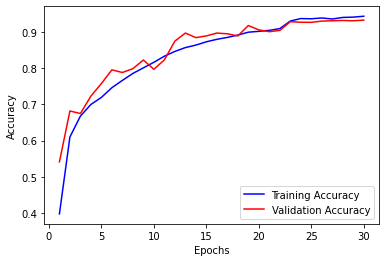

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       667
           1       0.98      0.99      0.98       639
           2       0.84      0.93      0.88       589
           3       1.00      0.99      0.99       449
           4       0.95      0.88      0.91       311
           5       0.90      0.81      0.85       289
           6       0.92      0.91      0.91       222
           7       0.94      0.92      0.93       253

    accuracy                           0.94      3419
   macro avg       0.94      0.92      0.93      3419
weighted avg       0.94      0.94      0.94      3419



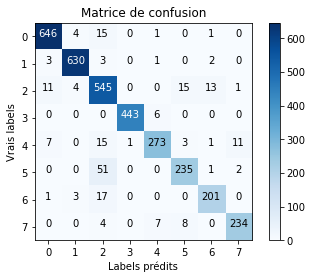

Durée : 477.445 sec


In [6]:
my_CNN(data_df, 60, "rgb")

## TEST Dense 96

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 16:46:49.164715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.7714 - accuracy: 0.3111

2022-01-16 16:47:04.351704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 18s 51ms/step - loss: 1.7706 - accuracy: 0.3115 - val_loss: 1.0723 - val_accuracy: 0.6095
Epoch 2/30
321/321 [==============================] - 14s 43ms/step - loss: 1.1096 - accuracy: 0.5797 - val_loss: 0.9510 - val_accuracy: 0.6274
Epoch 3/30
321/321 [==============================] - 13s 40ms/step - loss: 0.9015 - accuracy: 0.6464 - val_loss: 0.8197 - val_accuracy: 0.6835
Epoch 4/30
321/321 [==============================] - 13s 39ms/step - loss: 0.8452 - accuracy: 0.6674 - val_loss: 0.7060 - val_accuracy: 0.7347
Epoch 5/30
321/321 [==============================] - 13s 39ms/step - loss: 0.7611 - accuracy: 0.7100 - val_loss: 0.6865 - val_accuracy: 0.7461
Epoch 6/30
321/321 [==============================] - 13s 40ms/step - loss: 0.6869 - accuracy: 0.7513 - val_loss: 0.6308 - val_accuracy: 0.7689
Epoch 7/30
321/321 [==============================] - 13s 41ms/step - loss: 0.6593 - accuracy: 0.7581 - val_loss: 0.6142 - val_accuracy: 0.7666
Epo

2022-01-16 16:53:24.306294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


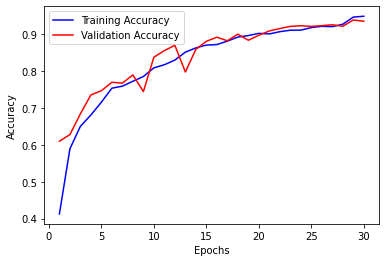

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       667
           1       0.98      0.99      0.98       639
           2       0.82      0.90      0.86       589
           3       1.00      0.99      0.99       449
           4       0.94      0.94      0.94       311
           5       0.87      0.81      0.84       289
           6       0.97      0.83      0.89       222
           7       0.96      0.92      0.94       253

    accuracy                           0.93      3419
   macro avg       0.94      0.92      0.93      3419
weighted avg       0.94      0.93      0.93      3419



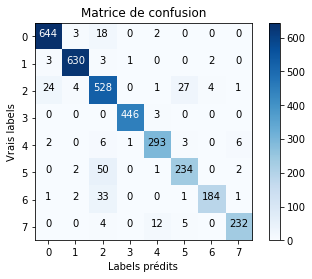

Durée : 436.257 sec


In [9]:
my_CNN(data_df, 60, "rgb")

## TEST Dense 64

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 18:01:46.034819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.7891 - accuracy: 0.2819

2022-01-16 18:02:04.986821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 21s 61ms/step - loss: 1.7882 - accuracy: 0.2823 - val_loss: 1.0769 - val_accuracy: 0.5522
Epoch 2/30
321/321 [==============================] - 12s 38ms/step - loss: 1.0752 - accuracy: 0.5660 - val_loss: 0.9312 - val_accuracy: 0.6335
Epoch 3/30
321/321 [==============================] - 12s 38ms/step - loss: 0.9279 - accuracy: 0.6360 - val_loss: 0.8562 - val_accuracy: 0.6479
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7832 - accuracy: 0.6978 - val_loss: 0.6288 - val_accuracy: 0.7684
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6887 - accuracy: 0.7389 - val_loss: 0.5454 - val_accuracy: 0.8037
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6119 - accuracy: 0.7667 - val_loss: 0.5259 - val_accuracy: 0.8005
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.5228 - accuracy: 0.8075 - val_loss: 0.4686 - val_accuracy: 0.8175
Epo

2022-01-16 18:07:25.246742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


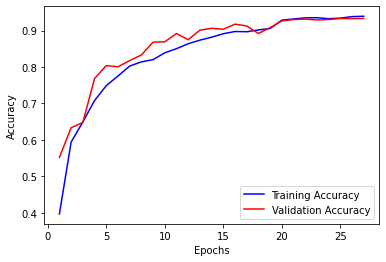

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       667
           1       0.99      0.99      0.99       639
           2       0.85      0.88      0.86       589
           3       1.00      0.99      1.00       449
           4       0.95      0.88      0.91       311
           5       0.83      0.86      0.84       289
           6       0.92      0.88      0.90       222
           7       0.91      0.95      0.93       253

    accuracy                           0.94      3419
   macro avg       0.93      0.92      0.93      3419
weighted avg       0.94      0.94      0.94      3419



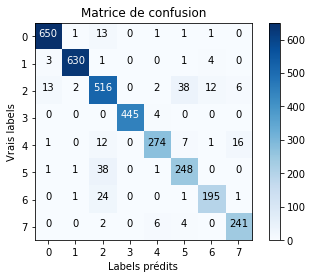

Durée : 372.972 sec


In [11]:
my_CNN(data_df, 60, "rgb")

## TEST Dense 32

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 18:56:55.113897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.8994 - accuracy: 0.2547

2022-01-16 18:57:09.094008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 17s 45ms/step - loss: 1.8986 - accuracy: 0.2551 - val_loss: 1.0239 - val_accuracy: 0.5999
Epoch 2/30
321/321 [==============================] - 12s 38ms/step - loss: 0.9763 - accuracy: 0.6184 - val_loss: 0.7779 - val_accuracy: 0.7008
Epoch 3/30
321/321 [==============================] - 12s 39ms/step - loss: 0.8117 - accuracy: 0.6952 - val_loss: 0.7913 - val_accuracy: 0.6850
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7736 - accuracy: 0.7159 - val_loss: 0.6912 - val_accuracy: 0.7423
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6989 - accuracy: 0.7421 - val_loss: 0.5903 - val_accuracy: 0.7853
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6427 - accuracy: 0.7578 - val_loss: 0.5733 - val_accuracy: 0.7719
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6197 - accuracy: 0.7594 - val_loss: 0.5477 - val_accuracy: 0.7920
Epo

2022-01-16 19:03:05.407544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


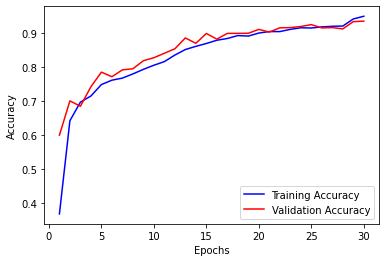

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       667
           1       0.98      0.99      0.99       639
           2       0.85      0.89      0.87       589
           3       1.00      0.99      0.99       449
           4       0.95      0.92      0.93       311
           5       0.89      0.85      0.87       289
           6       0.94      0.90      0.92       222
           7       0.95      0.94      0.95       253

    accuracy                           0.94      3419
   macro avg       0.94      0.93      0.94      3419
weighted avg       0.94      0.94      0.94      3419



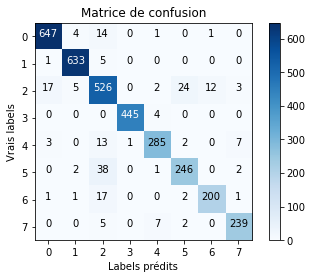

Durée : 403.137 sec


In [30]:
my_CNN(data_df, 60, "rgb")

## TEST Dense 16

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 19:03:53.038344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.8738 - accuracy: 0.2613

2022-01-16 19:04:06.474214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 16s 44ms/step - loss: 1.8730 - accuracy: 0.2615 - val_loss: 1.1453 - val_accuracy: 0.5481
Epoch 2/30
321/321 [==============================] - 12s 38ms/step - loss: 1.1424 - accuracy: 0.5473 - val_loss: 1.0044 - val_accuracy: 0.5929
Epoch 3/30
321/321 [==============================] - 12s 38ms/step - loss: 0.9532 - accuracy: 0.6174 - val_loss: 0.7918 - val_accuracy: 0.6982
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8371 - accuracy: 0.6826 - val_loss: 0.7364 - val_accuracy: 0.7178
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7492 - accuracy: 0.7184 - val_loss: 0.6334 - val_accuracy: 0.7701
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6847 - accuracy: 0.7481 - val_loss: 0.5830 - val_accuracy: 0.7821
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.5947 - accuracy: 0.7681 - val_loss: 0.6153 - val_accuracy: 0.7681
Epo

2022-01-16 19:09:50.255180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


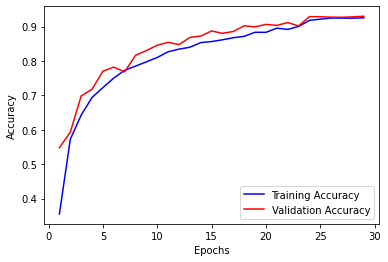

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       667
           1       0.98      0.99      0.98       639
           2       0.85      0.86      0.86       589
           3       1.00      0.99      0.99       449
           4       0.96      0.92      0.94       311
           5       0.84      0.81      0.82       289
           6       0.90      0.90      0.90       222
           7       0.94      0.94      0.94       253

    accuracy                           0.93      3419
   macro avg       0.93      0.92      0.93      3419
weighted avg       0.93      0.93      0.93      3419



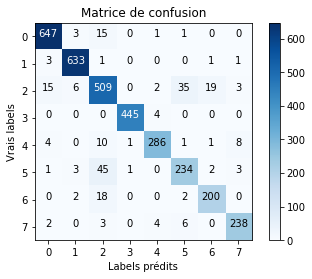

Durée : 380.438 sec


In [32]:
my_CNN(data_df, 60, "rgb")

## TEST Dense 8

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 19:10:47.904388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.9163 - accuracy: 0.2448

2022-01-16 19:11:01.531891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 16s 44ms/step - loss: 1.9157 - accuracy: 0.2451 - val_loss: 1.3097 - val_accuracy: 0.5405
Epoch 2/30
321/321 [==============================] - 12s 39ms/step - loss: 1.2414 - accuracy: 0.5375 - val_loss: 0.9494 - val_accuracy: 0.6607
Epoch 3/30
321/321 [==============================] - 12s 38ms/step - loss: 0.9995 - accuracy: 0.6250 - val_loss: 0.8554 - val_accuracy: 0.6835
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8862 - accuracy: 0.6619 - val_loss: 0.8007 - val_accuracy: 0.6941
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8349 - accuracy: 0.6871 - val_loss: 0.9584 - val_accuracy: 0.6291
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7874 - accuracy: 0.7033 - val_loss: 0.6944 - val_accuracy: 0.7403
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7330 - accuracy: 0.7283 - val_loss: 0.6338 - val_accuracy: 0.7719
Epo

2022-01-16 19:16:59.022741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


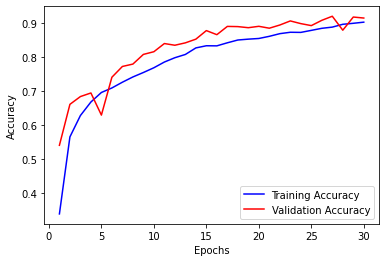

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       667
           1       0.99      0.97      0.98       639
           2       0.77      0.92      0.84       589
           3       0.99      0.99      0.99       449
           4       0.96      0.90      0.93       311
           5       0.91      0.74      0.82       289
           6       0.89      0.81      0.84       222
           7       0.96      0.94      0.95       253

    accuracy                           0.92      3419
   macro avg       0.93      0.90      0.91      3419
weighted avg       0.93      0.92      0.92      3419



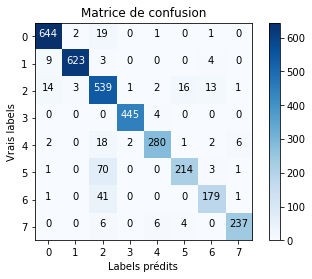

Durée : 400.819 sec


In [34]:
my_CNN(data_df, 60, "rgb")

## Gray

In [36]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_gray.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 19:21:34.136037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.8876 - accuracy: 0.2477

2022-01-16 19:21:46.290473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 21s 41ms/step - loss: 1.8868 - accuracy: 0.2481 - val_loss: 1.0582 - val_accuracy: 0.5686
Epoch 2/30
321/321 [==============================] - 12s 37ms/step - loss: 0.9855 - accuracy: 0.6244 - val_loss: 0.8496 - val_accuracy: 0.6791
Epoch 3/30
321/321 [==============================] - 12s 37ms/step - loss: 0.8721 - accuracy: 0.6699 - val_loss: 0.7290 - val_accuracy: 0.7321
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8061 - accuracy: 0.6936 - val_loss: 0.7458 - val_accuracy: 0.7213
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7778 - accuracy: 0.7015 - val_loss: 0.6957 - val_accuracy: 0.7406
Epoch 6/30
321/321 [==============================] - 12s 37ms/step - loss: 0.7163 - accuracy: 0.7254 - val_loss: 0.6362 - val_accuracy: 0.7640
Epoch 7/30
321/321 [==============================] - 12s 37ms/step - loss: 0.6920 - accuracy: 0.7402 - val_loss: 0.6763 - val_accuracy: 0.7479
Epo

2022-01-16 19:27:14.099097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


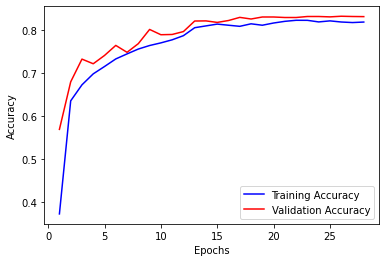

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       667
           1       0.86      0.93      0.89       639
           2       0.66      0.71      0.68       589
           3       1.00      0.99      0.99       449
           4       0.91      0.79      0.85       311
           5       0.66      0.55      0.60       289
           6       0.76      0.72      0.74       222
           7       0.84      0.87      0.85       253

    accuracy                           0.84      3419
   macro avg       0.83      0.81      0.82      3419
weighted avg       0.84      0.84      0.84      3419



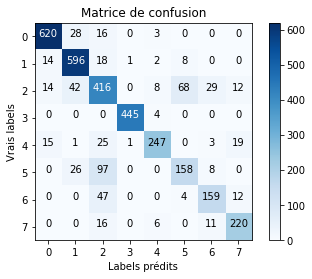

Durée : 357.5 sec


In [37]:
my_CNN(data_df, 60, "gray")

## HSV

In [38]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_hsv.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 19:28:02.015625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.7239 - accuracy: 0.3425

2022-01-16 19:28:15.119669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 16s 44ms/step - loss: 1.7231 - accuracy: 0.3429 - val_loss: 1.0173 - val_accuracy: 0.6338
Epoch 2/30
321/321 [==============================] - 12s 38ms/step - loss: 0.9917 - accuracy: 0.6250 - val_loss: 0.7809 - val_accuracy: 0.7318
Epoch 3/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8457 - accuracy: 0.6904 - val_loss: 0.7246 - val_accuracy: 0.7350
Epoch 4/30
321/321 [==============================] - 12s 39ms/step - loss: 0.7608 - accuracy: 0.7225 - val_loss: 0.7990 - val_accuracy: 0.7134
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7102 - accuracy: 0.7395 - val_loss: 0.6205 - val_accuracy: 0.7786
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6719 - accuracy: 0.7458 - val_loss: 0.5810 - val_accuracy: 0.7877
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6424 - accuracy: 0.7568 - val_loss: 0.6250 - val_accuracy: 0.7640
Epo

2022-01-16 19:32:08.089172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


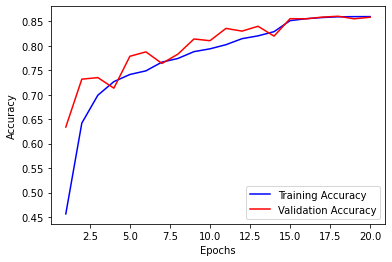

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       667
           1       0.96      0.97      0.97       639
           2       0.67      0.82      0.74       589
           3       1.00      0.99      0.99       449
           4       0.93      0.81      0.86       311
           5       0.75      0.57      0.65       289
           6       0.68      0.64      0.66       222
           7       0.82      0.81      0.81       253

    accuracy                           0.86      3419
   macro avg       0.85      0.82      0.83      3419
weighted avg       0.87      0.86      0.86      3419



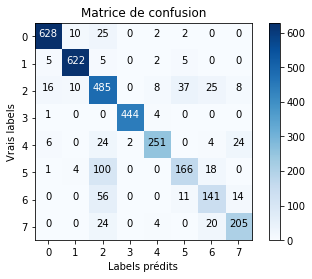

Durée : 281.435 sec


In [39]:
my_CNN(data_df, 60, "hsv")

## LAB

In [40]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_lab.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 19:32:49.547003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.9249 - accuracy: 0.2482

2022-01-16 19:33:02.148707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 15s 42ms/step - loss: 1.9241 - accuracy: 0.2485 - val_loss: 1.1706 - val_accuracy: 0.5469
Epoch 2/30
321/321 [==============================] - 12s 38ms/step - loss: 1.0649 - accuracy: 0.6011 - val_loss: 1.2654 - val_accuracy: 0.4934
Epoch 3/30
321/321 [==============================] - 13s 39ms/step - loss: 0.9292 - accuracy: 0.6499 - val_loss: 0.7383 - val_accuracy: 0.7218
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8011 - accuracy: 0.7009 - val_loss: 0.7603 - val_accuracy: 0.7125
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7669 - accuracy: 0.7212 - val_loss: 0.7212 - val_accuracy: 0.7259
Epoch 6/30
321/321 [==============================] - 12s 39ms/step - loss: 0.7232 - accuracy: 0.7243 - val_loss: 0.6737 - val_accuracy: 0.7397
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7049 - accuracy: 0.7413 - val_loss: 0.6520 - val_accuracy: 0.7526
Epo

2022-01-16 19:38:56.932932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


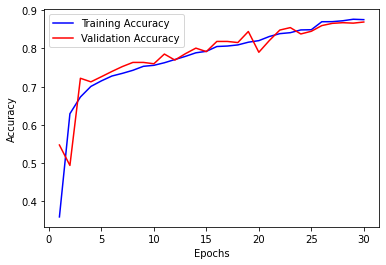

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       667
           1       0.97      0.96      0.96       639
           2       0.73      0.79      0.76       589
           3       1.00      1.00      1.00       449
           4       0.94      0.82      0.88       311
           5       0.72      0.70      0.71       289
           6       0.72      0.61      0.66       222
           7       0.84      0.83      0.83       253

    accuracy                           0.87      3419
   macro avg       0.85      0.83      0.84      3419
weighted avg       0.87      0.87      0.87      3419



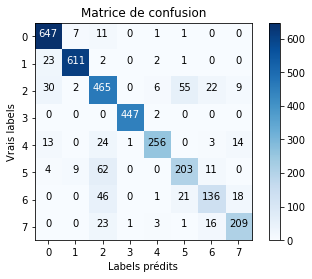

Durée : 396.862 sec


In [41]:
my_CNN(data_df, 60, "lab")

## Canny

In [42]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_canny.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 19:49:25.868159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.7453 - accuracy: 0.3179

2022-01-16 19:49:37.608928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 14s 39ms/step - loss: 1.7446 - accuracy: 0.3182 - val_loss: 1.2754 - val_accuracy: 0.5174
Epoch 2/30
321/321 [==============================] - 12s 38ms/step - loss: 1.2705 - accuracy: 0.5168 - val_loss: 1.1772 - val_accuracy: 0.5461
Epoch 3/30
321/321 [==============================] - 12s 37ms/step - loss: 1.1320 - accuracy: 0.5621 - val_loss: 1.0963 - val_accuracy: 0.5724
Epoch 4/30
321/321 [==============================] - 12s 37ms/step - loss: 1.0608 - accuracy: 0.5892 - val_loss: 1.0743 - val_accuracy: 0.5914
Epoch 5/30
321/321 [==============================] - 12s 37ms/step - loss: 1.0294 - accuracy: 0.6010 - val_loss: 1.0419 - val_accuracy: 0.6034
Epoch 6/30
321/321 [==============================] - 12s 37ms/step - loss: 0.9876 - accuracy: 0.6263 - val_loss: 1.0391 - val_accuracy: 0.6002
Epoch 7/30
321/321 [==============================] - 12s 37ms/step - loss: 0.9430 - accuracy: 0.6440 - val_loss: 1.0470 - val_accuracy: 0.5973
Epo

2022-01-16 19:52:15.500966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


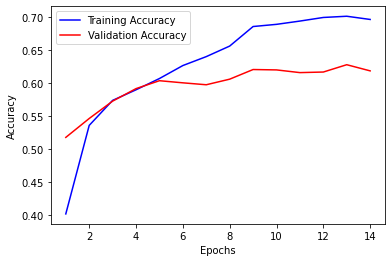

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       667
           1       0.56      0.73      0.63       639
           2       0.51      0.53      0.52       589
           3       0.94      0.94      0.94       449
           4       0.67      0.59      0.63       311
           5       0.48      0.34      0.39       289
           6       0.49      0.33      0.40       222
           7       0.73      0.80      0.77       253

    accuracy                           0.64      3419
   macro avg       0.63      0.61      0.62      3419
weighted avg       0.64      0.64      0.63      3419



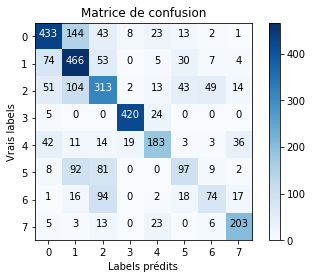

Durée : 177.29 sec


In [43]:
my_CNN(data_df, 60, "canny")

## Otsu

In [44]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_otsu.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 19:52:26.099712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.5021 - accuracy: 0.4437

2022-01-16 19:52:37.651158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 15s 40ms/step - loss: 1.5012 - accuracy: 0.4440 - val_loss: 0.8954 - val_accuracy: 0.6595
Epoch 2/30
321/321 [==============================] - 13s 39ms/step - loss: 0.8711 - accuracy: 0.6749 - val_loss: 0.7281 - val_accuracy: 0.7251
Epoch 3/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7684 - accuracy: 0.7075 - val_loss: 0.7342 - val_accuracy: 0.7107
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7156 - accuracy: 0.7310 - val_loss: 0.6534 - val_accuracy: 0.7631
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6794 - accuracy: 0.7456 - val_loss: 0.6659 - val_accuracy: 0.7605
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6248 - accuracy: 0.7657 - val_loss: 0.6362 - val_accuracy: 0.7742
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.5867 - accuracy: 0.7790 - val_loss: 0.6565 - val_accuracy: 0.7602
Epo

2022-01-16 19:55:54.208709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


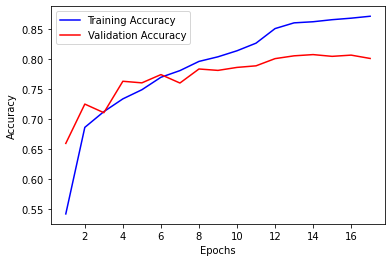

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       667
           1       0.89      0.83      0.86       639
           2       0.66      0.72      0.69       589
           3       0.98      0.96      0.97       449
           4       0.87      0.81      0.84       311
           5       0.63      0.67      0.65       289
           6       0.59      0.58      0.58       222
           7       0.80      0.87      0.83       253

    accuracy                           0.82      3419
   macro avg       0.79      0.79      0.79      3419
weighted avg       0.82      0.82      0.82      3419



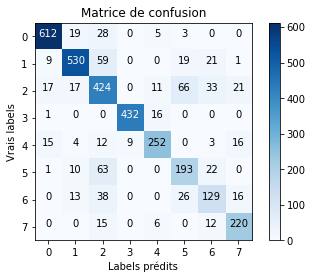

Durée : 216.9 sec


In [45]:
my_CNN(data_df, 60, "otsu")

## Otsu_Canny

In [46]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_otsu_canny.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 19:56:03.801672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.6571 - accuracy: 0.3559

2022-01-16 19:56:15.562312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 14s 40ms/step - loss: 1.6564 - accuracy: 0.3562 - val_loss: 1.2288 - val_accuracy: 0.5276
Epoch 2/30
321/321 [==============================] - 12s 38ms/step - loss: 1.1539 - accuracy: 0.5578 - val_loss: 1.2002 - val_accuracy: 0.5475
Epoch 3/30
321/321 [==============================] - 12s 37ms/step - loss: 1.0680 - accuracy: 0.5964 - val_loss: 1.0654 - val_accuracy: 0.5932
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 1.0361 - accuracy: 0.6094 - val_loss: 1.0436 - val_accuracy: 0.6022
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.9797 - accuracy: 0.6288 - val_loss: 1.0134 - val_accuracy: 0.6125
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.9394 - accuracy: 0.6466 - val_loss: 1.0051 - val_accuracy: 0.6204
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.9184 - accuracy: 0.6578 - val_loss: 1.0258 - val_accuracy: 0.6113
Epo

2022-01-16 19:59:43.542135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


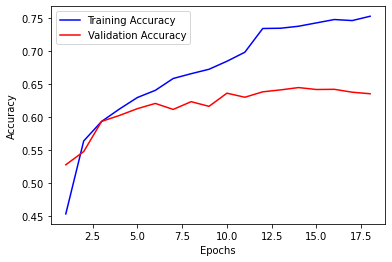

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       667
           1       0.57      0.62      0.60       639
           2       0.56      0.65      0.60       589
           3       0.96      0.96      0.96       449
           4       0.69      0.61      0.65       311
           5       0.61      0.46      0.52       289
           6       0.36      0.19      0.25       222
           7       0.78      0.79      0.79       253

    accuracy                           0.67      3419
   macro avg       0.66      0.63      0.64      3419
weighted avg       0.67      0.67      0.67      3419



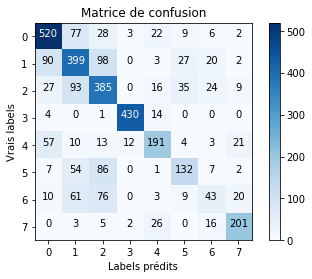

Durée : 227.078 sec


In [47]:
my_CNN(data_df, 60, "otsu_canny")

## Threshold_color

In [48]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_threshold_color.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 20:00:15.558406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.5888 - accuracy: 0.3869

2022-01-16 20:00:27.703819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 14s 41ms/step - loss: 1.5880 - accuracy: 0.3872 - val_loss: 0.9792 - val_accuracy: 0.6037
Epoch 2/30
321/321 [==============================] - 12s 39ms/step - loss: 0.9782 - accuracy: 0.6304 - val_loss: 0.7638 - val_accuracy: 0.6938
Epoch 3/30
321/321 [==============================] - 13s 39ms/step - loss: 0.8018 - accuracy: 0.6930 - val_loss: 0.7179 - val_accuracy: 0.7257
Epoch 4/30
321/321 [==============================] - 13s 41ms/step - loss: 0.6594 - accuracy: 0.7512 - val_loss: 0.5175 - val_accuracy: 0.8119
Epoch 5/30
321/321 [==============================] - 13s 39ms/step - loss: 0.5608 - accuracy: 0.7844 - val_loss: 0.4511 - val_accuracy: 0.8295
Epoch 6/30
321/321 [==============================] - 12s 39ms/step - loss: 0.4985 - accuracy: 0.8079 - val_loss: 0.4626 - val_accuracy: 0.8210
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.4530 - accuracy: 0.8307 - val_loss: 0.3890 - val_accuracy: 0.8541
Epo

2022-01-16 20:05:00.580751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


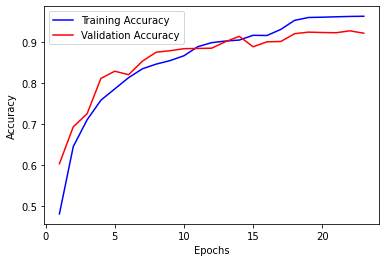

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       667
           1       0.99      0.95      0.97       639
           2       0.85      0.86      0.86       589
           3       0.99      0.99      0.99       449
           4       0.94      0.91      0.92       311
           5       0.90      0.79      0.84       289
           6       0.83      0.92      0.88       222
           7       0.90      0.92      0.91       253

    accuracy                           0.92      3419
   macro avg       0.92      0.91      0.91      3419
weighted avg       0.92      0.92      0.92      3419



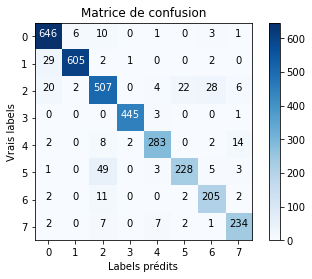

Durée : 310.992 sec


In [49]:
my_CNN(data_df, 60, "threshold_color")

## Threshold_color + gray

In [50]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_threshold_color_g.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 20:05:12.238882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.5796 - accuracy: 0.3964

2022-01-16 20:05:23.803139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 14s 39ms/step - loss: 1.5787 - accuracy: 0.3967 - val_loss: 1.1116 - val_accuracy: 0.5443
Epoch 2/30
321/321 [==============================] - 12s 37ms/step - loss: 0.9916 - accuracy: 0.6014 - val_loss: 0.8819 - val_accuracy: 0.6598
Epoch 3/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8438 - accuracy: 0.6587 - val_loss: 0.7599 - val_accuracy: 0.7037
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7344 - accuracy: 0.7108 - val_loss: 0.6620 - val_accuracy: 0.7344
Epoch 5/30
321/321 [==============================] - 12s 37ms/step - loss: 0.6518 - accuracy: 0.7455 - val_loss: 0.6093 - val_accuracy: 0.7666
Epoch 6/30
321/321 [==============================] - 12s 37ms/step - loss: 0.6184 - accuracy: 0.7656 - val_loss: 0.5860 - val_accuracy: 0.7768
Epoch 7/30
321/321 [==============================] - 12s 37ms/step - loss: 0.5644 - accuracy: 0.7833 - val_loss: 0.5680 - val_accuracy: 0.7803
Epo

2022-01-16 20:09:37.393488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


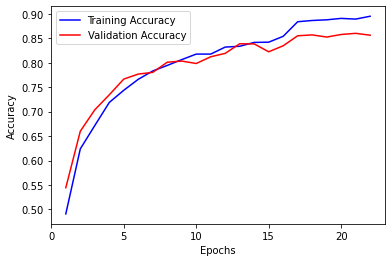

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       667
           1       0.84      0.85      0.84       639
           2       0.73      0.77      0.75       589
           3       0.99      0.99      0.99       449
           4       0.91      0.91      0.91       311
           5       0.76      0.67      0.71       289
           6       0.86      0.87      0.87       222
           7       0.93      0.88      0.90       253

    accuracy                           0.86      3419
   macro avg       0.86      0.85      0.86      3419
weighted avg       0.86      0.86      0.86      3419



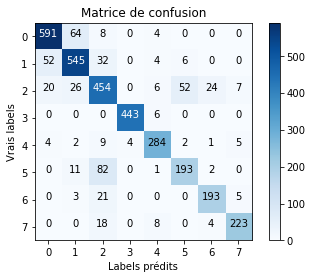

Durée : 272.678 sec


In [51]:
my_CNN(data_df, 60, "threshold_color_g")

## Kmeans1

In [52]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_kmeans1.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 20:10:11.156841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.8455 - accuracy: 0.2680

2022-01-16 20:10:23.234232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 15s 42ms/step - loss: 1.8446 - accuracy: 0.2684 - val_loss: 0.9822 - val_accuracy: 0.6394
Epoch 2/30
321/321 [==============================] - 12s 39ms/step - loss: 1.0151 - accuracy: 0.6216 - val_loss: 0.8369 - val_accuracy: 0.6832
Epoch 3/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8712 - accuracy: 0.6702 - val_loss: 0.8010 - val_accuracy: 0.7043
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8260 - accuracy: 0.6880 - val_loss: 0.7074 - val_accuracy: 0.7271
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7301 - accuracy: 0.7255 - val_loss: 0.6392 - val_accuracy: 0.7602
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6733 - accuracy: 0.7468 - val_loss: 0.6245 - val_accuracy: 0.7684
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.6230 - accuracy: 0.7695 - val_loss: 0.6172 - val_accuracy: 0.7593
Epo

2022-01-16 20:14:29.564336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


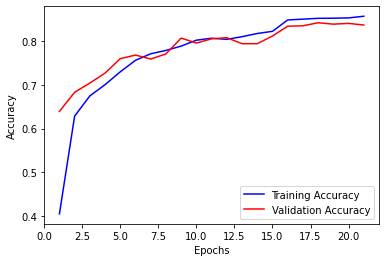

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       667
           1       0.94      0.89      0.91       639
           2       0.67      0.71      0.69       589
           3       0.99      0.99      0.99       449
           4       0.85      0.86      0.85       311
           5       0.69      0.65      0.67       289
           6       0.84      0.58      0.69       222
           7       0.76      0.91      0.83       253

    accuracy                           0.84      3419
   macro avg       0.83      0.81      0.82      3419
weighted avg       0.84      0.84      0.84      3419



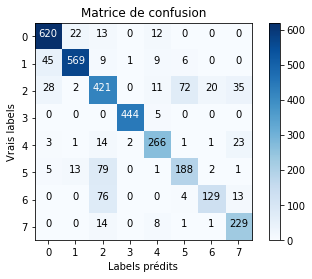

Durée : 285.223 sec


In [53]:
my_CNN(data_df, 60, "kmeans1")

## Kmeans2

In [54]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_kmeans2.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 20:15:12.565258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.5064 - accuracy: 0.4206

2022-01-16 20:15:25.962993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 16s 44ms/step - loss: 1.5054 - accuracy: 0.4210 - val_loss: 0.8026 - val_accuracy: 0.6882
Epoch 2/30
321/321 [==============================] - 13s 40ms/step - loss: 0.7774 - accuracy: 0.7053 - val_loss: 0.5997 - val_accuracy: 0.7745
Epoch 3/30
321/321 [==============================] - 12s 38ms/step - loss: 0.5791 - accuracy: 0.7908 - val_loss: 0.4405 - val_accuracy: 0.8535
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.4995 - accuracy: 0.8213 - val_loss: 0.4561 - val_accuracy: 0.8371
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.4589 - accuracy: 0.8320 - val_loss: 0.4382 - val_accuracy: 0.8470
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.4023 - accuracy: 0.8541 - val_loss: 0.4785 - val_accuracy: 0.8198

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
321/321 [==============================] - 12s 38ms/st

2022-01-16 20:17:44.839779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


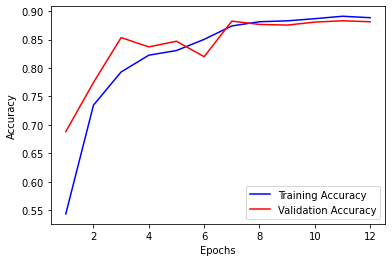

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       667
           1       0.94      0.93      0.94       639
           2       0.73      0.79      0.76       589
           3       1.00      1.00      1.00       449
           4       0.94      0.85      0.89       311
           5       0.85      0.68      0.76       289
           6       0.80      0.89      0.84       222
           7       0.85      0.87      0.86       253

    accuracy                           0.88      3419
   macro avg       0.88      0.87      0.87      3419
weighted avg       0.89      0.88      0.88      3419



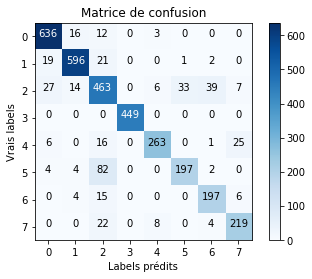

Durée : 184.461 sec


In [55]:
my_CNN(data_df, 60, "kmeans2")

## KmeansXYRGB

In [56]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_kmeansXYRGB.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 20:18:49.893460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.8666 - accuracy: 0.2630

2022-01-16 20:19:02.691009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 15s 43ms/step - loss: 1.8658 - accuracy: 0.2633 - val_loss: 1.1110 - val_accuracy: 0.5973
Epoch 2/30
321/321 [==============================] - 12s 39ms/step - loss: 1.1218 - accuracy: 0.5897 - val_loss: 0.8618 - val_accuracy: 0.6949
Epoch 3/30
321/321 [==============================] - 12s 38ms/step - loss: 0.9380 - accuracy: 0.6534 - val_loss: 0.8599 - val_accuracy: 0.6865
Epoch 4/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8911 - accuracy: 0.6695 - val_loss: 0.7393 - val_accuracy: 0.7254
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8621 - accuracy: 0.6669 - val_loss: 0.7613 - val_accuracy: 0.7175
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.8306 - accuracy: 0.6967 - val_loss: 0.7073 - val_accuracy: 0.7362
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.7928 - accuracy: 0.7038 - val_loss: 0.7120 - val_accuracy: 0.7458
Epo

2022-01-16 20:23:22.073046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


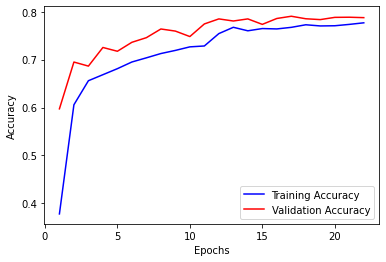

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       682
           1       0.88      0.93      0.91       627
           2       0.56      0.73      0.63       590
           3       0.97      0.97      0.97       449
           4       0.87      0.77      0.82       311
           5       0.61      0.23      0.34       302
           6       0.55      0.63      0.59       222
           7       0.76      0.76      0.76       236

    accuracy                           0.79      3419
   macro avg       0.77      0.74      0.74      3419
weighted avg       0.80      0.79      0.79      3419



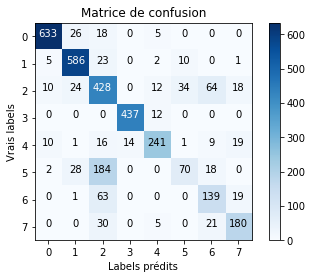

Durée : 318.206 sec


In [57]:
my_CNN(data_df, 60, "kmeansXYRGB")

## Equalizer

In [61]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_equalizer.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-16 21:20:15.626544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.6873 - accuracy: 0.3647

2022-01-16 21:20:28.495291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 15s 42ms/step - loss: 1.6863 - accuracy: 0.3650 - val_loss: 0.8914 - val_accuracy: 0.6774
Epoch 2/30
321/321 [==============================] - 13s 40ms/step - loss: 0.8727 - accuracy: 0.6613 - val_loss: 0.7242 - val_accuracy: 0.7122
Epoch 3/30
321/321 [==============================] - 13s 39ms/step - loss: 0.6784 - accuracy: 0.7304 - val_loss: 0.5904 - val_accuracy: 0.7651
Epoch 4/30
321/321 [==============================] - 13s 39ms/step - loss: 0.6126 - accuracy: 0.7535 - val_loss: 0.6243 - val_accuracy: 0.7590
Epoch 5/30
321/321 [==============================] - 12s 38ms/step - loss: 0.5971 - accuracy: 0.7623 - val_loss: 0.5696 - val_accuracy: 0.7748
Epoch 6/30
321/321 [==============================] - 12s 38ms/step - loss: 0.5568 - accuracy: 0.7772 - val_loss: 0.5358 - val_accuracy: 0.7953
Epoch 7/30
321/321 [==============================] - 12s 38ms/step - loss: 0.5162 - accuracy: 0.7949 - val_loss: 0.5275 - val_accuracy: 0.7985
Epo

2022-01-16 21:25:00.181658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


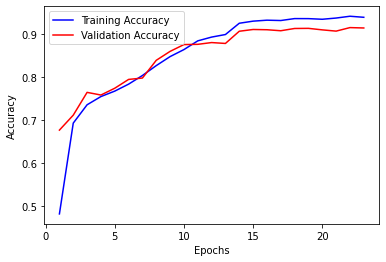

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       682
           1       1.00      0.98      0.99       627
           2       0.82      0.85      0.84       590
           3       0.97      0.98      0.98       449
           4       0.95      0.86      0.90       311
           5       0.87      0.83      0.85       302
           6       0.80      0.79      0.79       222
           7       0.89      0.97      0.93       236

    accuracy                           0.92      3419
   macro avg       0.91      0.91      0.91      3419
weighted avg       0.92      0.92      0.92      3419



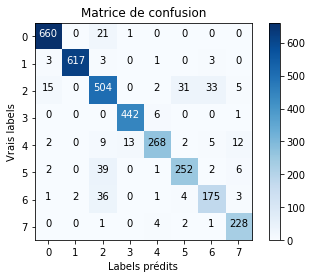

Durée : 333.735 sec


In [62]:
my_CNN(data_df, 60, "equalizer")

## Mean Shift

In [9]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_mean_shift.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Metal device set to: Apple M1


2022-01-18 11:09:38.940511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-18 11:09:38.941171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-18 11:09:42.478240: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-18 11:09:42.481355: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-01-18 11:09:51.318625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.8650 - accuracy: 0.2507

2022-01-18 11:10:04.961849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 24s 44ms/step - loss: 1.8641 - accuracy: 0.2511 - val_loss: 1.0411 - val_accuracy: 0.6075
Epoch 2/30
321/321 [==============================] - 13s 41ms/step - loss: 1.0412 - accuracy: 0.5951 - val_loss: 0.8513 - val_accuracy: 0.6882
Epoch 3/30
321/321 [==============================] - 13s 40ms/step - loss: 0.8660 - accuracy: 0.6543 - val_loss: 0.7933 - val_accuracy: 0.7017
Epoch 4/30
321/321 [==============================] - 13s 39ms/step - loss: 0.7840 - accuracy: 0.7007 - val_loss: 0.6883 - val_accuracy: 0.7397
Epoch 5/30
321/321 [==============================] - 14s 43ms/step - loss: 0.7714 - accuracy: 0.7052 - val_loss: 0.6881 - val_accuracy: 0.7397
Epoch 6/30
321/321 [==============================] - 13s 40ms/step - loss: 0.7193 - accuracy: 0.7281 - val_loss: 0.6613 - val_accuracy: 0.7312
Epoch 7/30
321/321 [==============================] - 14s 43ms/step - loss: 0.6654 - accuracy: 0.7425 - val_loss: 0.6159 - val_accuracy: 0.7754
Epo

2022-01-18 11:15:26.811376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


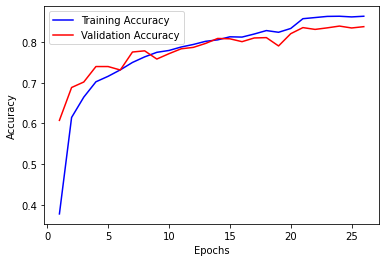

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       682
           1       0.83      0.93      0.88       627
           2       0.68      0.72      0.70       590
           3       0.99      1.00      0.99       449
           4       0.91      0.82      0.86       311
           5       0.66      0.54      0.60       302
           6       0.82      0.76      0.79       222
           7       0.83      0.86      0.85       236

    accuracy                           0.84      3419
   macro avg       0.83      0.82      0.83      3419
weighted avg       0.84      0.84      0.84      3419



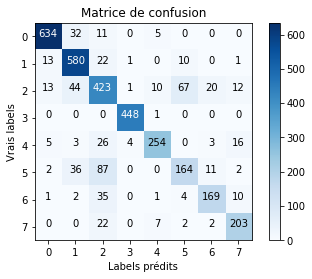

Durée : 384.219 sec


In [10]:
my_CNN(data_df, 60, "mean_shift")

## 2. Transfer Learning

In [5]:
def my_CNN_TL (dataset, size_img,img_filter, base_model):

    #---------------------------------------------PREPROCESSING---------------------------------------------#

    K.clear_session()                               # Libération de la mémoire
    start = time.time()                             # Lancement du timer
    dim = 0                                         # initialisation de la variable dim (dimension de l'image)
                                                    # Si l'image est en rgb alors "dim = 3"
        
    
    if (img_filter == "rgb" or img_filter == "hsv" or img_filter == "lab" or img_filter == "kmeans1" 
        or img_filter == "kmeans2" or img_filter == "kmeansXYRGB" or img_filter == "threshold_color" 
        or img_filter == "equalizer") :    
        dim = 3
    
    elif (img_filter=="gray" or img_filter=="canny" or img_filter=="otsu" or img_filter=="threshold_color_g" or 
          img_filter=="otsu_canny" ) :
        dim = 1
        
    else:
        print("img_filter = 'rgb','gray, 'hsv', 'lab', 'canny', 'otsu', 'kmeans1', 'kmeans2','kmeansXYRGB', 'threshold_color', 
               'threshold_color_g','otsu_canny', 'equalizer'")
      
    # On separe les features des labels
    X = dataset.drop(["type"], axis = 1)
    y = dataset["type"]
              
    # Encoder la varible y
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
              
    # On split le dataset general en set d'entrainement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)
    
    # On split le dataset d'entrainement en set d'entrainement et de validation
    # La distribution finale = train :60%, valid : 20%, test:20%
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state = 123)
        
    # conversion des dataframes en array et on reforme les images dans sa dimension initiale (60X60X3 ou 60X60X1)
    X_train = np.array(X_train)
    X_train = X_train.reshape(-1, size_img,size_img,dim).astype(int)
    
    X_valid = np.array(X_valid)
    X_valid = X_valid.reshape(-1, size_img,size_img,dim).astype(int)

    X_test = np.array(X_test)
    X_test = X_test.reshape(-1, size_img,size_img,dim).astype(int)

    # On normalise les données des 3 sets
    X_train = X_train / 255
    X_valid = X_valid / 255
    X_test = X_test / 255

    # On binarise les labels
    y_train = np_utils.to_categorical(y_train)
    y_valid = np_utils.to_categorical(y_valid)
    y_test = np_utils.to_categorical(y_test)
    
    # On recupère le nombre de classe 
    num_classes = y_train.shape[1]
    

    #---------------------------------------------CALLBACKS---------------------------------------------#
    # Stoppe le processus lorsque "val_loss" ne diminue pas de 1% sur 5 epochs
    early_stopping = EarlyStopping(
                                patience=5, # Attendre 5 epochs avant application
                                min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
                                # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'min',
                                monitor='val_loss')
    
    # Réduit le taux d'apprentissage lorsque "val_loss" a arrêté de diminuer sur 3 epochs,
    # on reduit le learning rate d'un facteur 0.1
    reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3,
                                    min_delta= 0.01,
                                    factor=0.1,  
                                    cooldown = 4,
                                    verbose=1)
    
    
    #-------------------------CREATION, ENTRAINEMENT ET PREDICTION DU MODELE-------------------------#
    # Si le model pré-entrainé choisi est le VGG16, alors on l'instancie 
    # et on entrainera les 4 dernieres couches de ce dernier
    if base_model == 'VGG16':
        pretrained_model = VGG16(weights='imagenet', include_top=False) 
        trainable_layers = 15
    # Si le model pré-entrainé choisi est le VGG19, alors on l'instancie 
    # et on entrainera les 5 dernieres couches de ce dernier
    elif base_model == 'VGG19':
        pretrained_model = VGG19(weights='imagenet', include_top=False) 
        trainable_layers =17
    # Si le model pré-entrainé choisi est le ResNet50, alors on l'instancie 
    # et on entrainera les 32 dernieres couches de ce dernier
    elif base_model == 'ResNet50':
        pretrained_model = ResNet50(weights='imagenet', include_top=False) 
        trainable_layers = 143
    # Si le model pré-entrainé choisi est le XCeption, alors on l'instancie 
    # et on entrainera les 6 dernieres couches de ce dernier
    elif base_model == 'Xception':
        pretrained_model = Xception(weights='imagenet', include_top=False) 
        trainable_layers = 126
    # Si le model choisit n'est pas connu, on rapelle les modèles selectionnables
    else:
        print("'base_model' must be 'VGG16', 'VGG19', 'ResNet50' or 'Xception'")
            
    # On freeze les couches du modèle pré-entrainé hormis les dernières couches (trainables_layers)
    for layer in pretrained_model.layers[:-trainable_layers]:
        layer.trainable = False
    
    # On construit le modèle
    model = Sequential([pretrained_model,
                        layers.GlobalAveragePooling2D(),
                        layers.Dropout(0.1),
                        layers.Dense(num_classes, activation='softmax')
                       ])
    #Compilation du modèle
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # On entraine le modèle et on stocke les résultats
    # (loss et accuracy pour le train et la validation) dans history
    epochs = 30
    training_history = model.fit(X_train, y_train,
                                 validation_data = (X_valid,y_valid),
                                 epochs = epochs,
                                 batch_size = 32,
                                 callbacks = [reduce_learning_rate,
                                            
                                              early_stopping])
    #Prédiction du modèle sur le dataset Test
    test_pred = model.predict(X_test)

    
    test_pred_class = test_pred.argmax(axis = 1)
    y_test_class = y_test.argmax(axis = 1)
    
    
    #----------------------------------------DATAVIZ et RESULTATS----------------------------------------#
    
    #Si le processus ne s'arrete pas, le nombre d'épochs retenu est celui choisi plus haut +1
    #Sinon, le nombre d'épochs retenu est celui de l'arrêt +2
    if early_stopping.stopped_epoch == 0:
        stop_epochs = epochs + 1
    else:
        stop_epochs = early_stopping.stopped_epoch + 2
    
    
    # Courbe de précision sur l'échantillon d'entrainement via epochs
    plt.plot(np.arange(1 , stop_epochs, 1),
             training_history.history['accuracy'],
             label = 'Training Accuracy',
             color = 'blue')

    # Courbe de précision sur l'échantillon de validation via epochs
    plt.plot(np.arange(1 ,stop_epochs, 1),
             training_history.history['val_accuracy'], 
             label = 'Validation Accuracy',
             color = 'red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Rapport de classification 
    print(classification_report(y_test_class, test_pred_class))
    
    # Matrice de confusion
    cnf_matrix = confusion_matrix(y_test_class, test_pred_class)

    plt.figure()
    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(range(0,8)))
    plt.xticks(tick_marks, range(0,8))
    plt.yticks(tick_marks, range(0,8))
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()
    #----------------------------------------DATAVIZ et RESULTATS----------------------------------------#

    
    #model.save(path_models + 'my_CNN_TL_ResNet50.h5')
    
    # Arret du timer et affichage de la durée du process
    end = time.time()
    duration = end - start
    print('Durée :', round(duration,3), 'sec')

## TL VGG16

##### RGB

In [6]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_rgb.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 17:40:16.223495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.8375 - accuracy: 0.2922

2022-01-18 17:41:01.787635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 101s 156ms/step - loss: 1.8365 - accuracy: 0.2926 - val_loss: 0.9923 - val_accuracy: 0.6385
Epoch 2/30
321/321 [==============================] - 48s 151ms/step - loss: 1.0151 - accuracy: 0.6106 - val_loss: 0.8841 - val_accuracy: 0.6546
Epoch 3/30
321/321 [==============================] - 48s 150ms/step - loss: 0.9542 - accuracy: 0.6321 - val_loss: 0.8363 - val_accuracy: 0.7333
Epoch 4/30
321/321 [==============================] - 48s 149ms/step - loss: 0.6139 - accuracy: 0.7651 - val_loss: 0.4192 - val_accuracy: 0.8514
Epoch 5/30
321/321 [==============================] - 48s 149ms/step - loss: 0.4821 - accuracy: 0.8186 - val_loss: 0.3347 - val_accuracy: 0.8795
Epoch 6/30
321/321 [==============================] - 48s 149ms/step - loss: 0.3742 - accuracy: 0.8613 - val_loss: 0.2889 - val_accuracy: 0.9044
Epoch 7/30
321/321 [==============================] - 48s 149ms/step - loss: 0.3062 - accuracy: 0.8903 - val_loss: 0.3168 - val_accuracy: 0.

2022-01-18 17:52:17.893397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


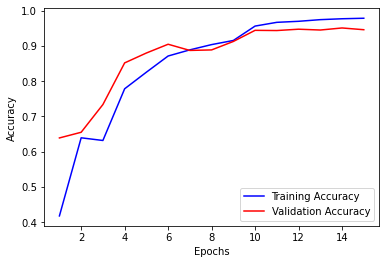

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       667
           1       1.00      0.99      0.99       639
           2       0.89      0.87      0.88       589
           3       1.00      0.99      0.99       449
           4       0.92      0.96      0.94       311
           5       0.88      0.92      0.90       289
           6       0.96      0.84      0.90       222
           7       0.97      0.94      0.96       253

    accuracy                           0.95      3419
   macro avg       0.94      0.94      0.94      3419
weighted avg       0.95      0.95      0.95      3419



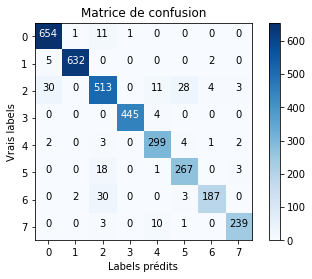

Durée : 817.72 sec


In [45]:
my_CNN_TL(data_df, 60, "rgb", "VGG16")

##### HSV

In [49]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_hsv.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 18:56:17.388340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 2.1254 - accuracy: 0.1782

2022-01-18 18:57:03.150512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 52s 155ms/step - loss: 2.1249 - accuracy: 0.1783 - val_loss: 1.6239 - val_accuracy: 0.2995
Epoch 2/30
321/321 [==============================] - 48s 148ms/step - loss: 1.5033 - accuracy: 0.3662 - val_loss: 1.1607 - val_accuracy: 0.4940
Epoch 3/30
321/321 [==============================] - 47s 148ms/step - loss: 1.1765 - accuracy: 0.4943 - val_loss: 0.9224 - val_accuracy: 0.5914
Epoch 4/30
321/321 [==============================] - 47s 148ms/step - loss: 0.8680 - accuracy: 0.6638 - val_loss: 0.7078 - val_accuracy: 0.7391
Epoch 5/30
321/321 [==============================] - 47s 147ms/step - loss: 0.6650 - accuracy: 0.7496 - val_loss: 0.5304 - val_accuracy: 0.7918
Epoch 6/30
321/321 [==============================] - 47s 148ms/step - loss: 0.5649 - accuracy: 0.7785 - val_loss: 0.4795 - val_accuracy: 0.8099
Epoch 7/30
321/321 [==============================] - 47s 147ms/step - loss: 0.5093 - accuracy: 0.8037 - val_loss: 0.5613 - val_accuracy: 0.7

2022-01-18 19:15:02.224943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


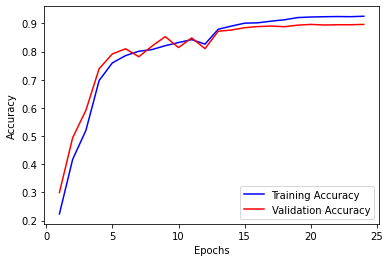

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       667
           1       0.98      0.97      0.97       639
           2       0.78      0.77      0.78       589
           3       1.00      1.00      1.00       449
           4       0.96      0.89      0.92       311
           5       0.75      0.72      0.73       289
           6       0.71      0.83      0.76       222
           7       0.88      0.87      0.88       253

    accuracy                           0.89      3419
   macro avg       0.88      0.88      0.88      3419
weighted avg       0.90      0.89      0.90      3419



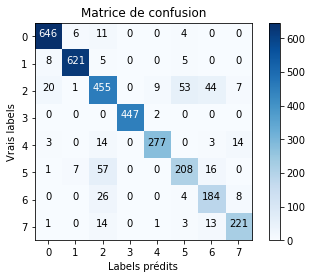

Durée : 1162.434 sec


In [50]:
my_CNN_TL(data_df, 60, "hsv", "VGG16")

##### Threshold color

In [32]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_threshold_color.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 20:19:09.167185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.9286 - accuracy: 0.2647

2022-01-18 20:19:54.784325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 52s 153ms/step - loss: 1.9276 - accuracy: 0.2650 - val_loss: 1.2137 - val_accuracy: 0.5139
Epoch 2/30
321/321 [==============================] - 48s 150ms/step - loss: 1.1754 - accuracy: 0.5177 - val_loss: 1.2834 - val_accuracy: 0.4858
Epoch 3/30
321/321 [==============================] - 48s 151ms/step - loss: 1.0513 - accuracy: 0.5583 - val_loss: 1.0196 - val_accuracy: 0.5809
Epoch 4/30
321/321 [==============================] - 48s 149ms/step - loss: 0.9384 - accuracy: 0.6111 - val_loss: 0.9739 - val_accuracy: 0.6019
Epoch 5/30
321/321 [==============================] - 48s 149ms/step - loss: 0.8307 - accuracy: 0.6634 - val_loss: 0.7846 - val_accuracy: 0.6730
Epoch 6/30
321/321 [==============================] - 48s 149ms/step - loss: 0.7376 - accuracy: 0.7114 - val_loss: 0.9716 - val_accuracy: 0.6274
Epoch 7/30
321/321 [==============================] - 47s 146ms/step - loss: 0.6981 - accuracy: 0.7350 - val_loss: 0.5467 - val_accuracy: 0.7

2022-01-18 20:36:45.783554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


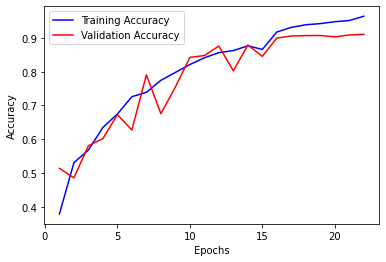

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       667
           1       0.91      0.95      0.93       639
           2       0.85      0.82      0.83       589
           3       1.00      1.00      1.00       449
           4       0.94      0.93      0.94       311
           5       0.79      0.85      0.82       289
           6       0.92      0.90      0.91       222
           7       0.91      0.92      0.91       253

    accuracy                           0.91      3419
   macro avg       0.91      0.91      0.91      3419
weighted avg       0.91      0.91      0.91      3419



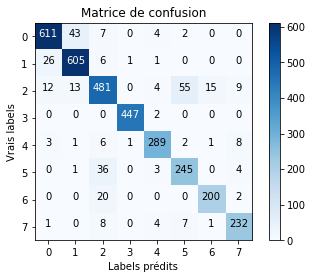

Durée : 1085.618 sec


In [55]:
my_CNN_TL(data_df, 60, "threshold_color", "VGG16")

##### Kmeans 2

In [59]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_kmeans2.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 21:20:41.499171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.6754 - accuracy: 0.3190

2022-01-18 21:21:26.604543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 51s 155ms/step - loss: 1.6744 - accuracy: 0.3193 - val_loss: 1.0103 - val_accuracy: 0.5648
Epoch 2/30
321/321 [==============================] - 49s 151ms/step - loss: 0.8661 - accuracy: 0.6466 - val_loss: 0.5947 - val_accuracy: 0.7730
Epoch 3/30
321/321 [==============================] - 48s 150ms/step - loss: 0.6714 - accuracy: 0.7632 - val_loss: 0.5818 - val_accuracy: 0.7885
Epoch 4/30
321/321 [==============================] - 48s 150ms/step - loss: 0.4994 - accuracy: 0.8246 - val_loss: 1.0311 - val_accuracy: 0.5408
Epoch 5/30
321/321 [==============================] - 48s 150ms/step - loss: 0.7893 - accuracy: 0.7166 - val_loss: 0.4670 - val_accuracy: 0.8371
Epoch 6/30
321/321 [==============================] - 48s 150ms/step - loss: 0.4756 - accuracy: 0.8355 - val_loss: 0.4641 - val_accuracy: 0.8397
Epoch 7/30
321/321 [==============================] - 48s 150ms/step - loss: 0.4503 - accuracy: 0.8509 - val_loss: 0.4881 - val_accuracy: 0.8

2022-01-18 21:35:59.228694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


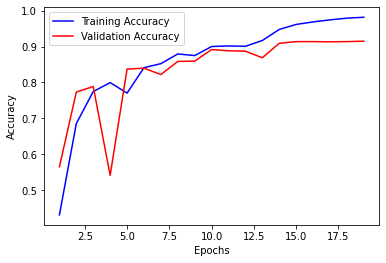

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       667
           1       0.97      0.96      0.97       639
           2       0.79      0.86      0.82       589
           3       1.00      1.00      1.00       449
           4       0.95      0.89      0.92       311
           5       0.85      0.79      0.82       289
           6       0.84      0.89      0.87       222
           7       0.91      0.86      0.88       253

    accuracy                           0.92      3419
   macro avg       0.91      0.90      0.91      3419
weighted avg       0.92      0.92      0.92      3419



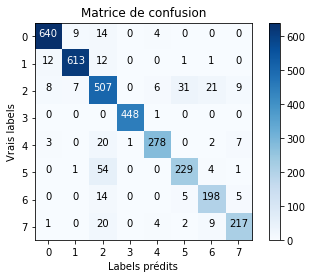

Durée : 951.823 sec


In [60]:
my_CNN_TL(data_df, 60, "kmeans2", "VGG16")

##### Kmeans XYRGB

In [64]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_kmeansXYRGB.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 22:30:34.534331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 2.0738 - accuracy: 0.1995

2022-01-18 22:31:19.442114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 51s 153ms/step - loss: 2.0730 - accuracy: 0.1998 - val_loss: 1.4298 - val_accuracy: 0.4183
Epoch 2/30
321/321 [==============================] - 48s 149ms/step - loss: 1.3151 - accuracy: 0.4706 - val_loss: 1.1023 - val_accuracy: 0.5645
Epoch 3/30
321/321 [==============================] - 50s 156ms/step - loss: 1.1326 - accuracy: 0.5493 - val_loss: 1.3055 - val_accuracy: 0.4762
Epoch 4/30
321/321 [==============================] - 47s 147ms/step - loss: 1.0987 - accuracy: 0.5696 - val_loss: 1.1048 - val_accuracy: 0.5624
Epoch 5/30
321/321 [==============================] - 48s 149ms/step - loss: 1.0192 - accuracy: 0.5953 - val_loss: 0.7661 - val_accuracy: 0.7061
Epoch 6/30
321/321 [==============================] - 48s 148ms/step - loss: 0.7422 - accuracy: 0.7229 - val_loss: 0.7585 - val_accuracy: 0.7128
Epoch 7/30
321/321 [==============================] - 50s 157ms/step - loss: 0.5944 - accuracy: 0.7770 - val_loss: 0.4788 - val_accuracy: 0.8

2022-01-18 22:48:38.057222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


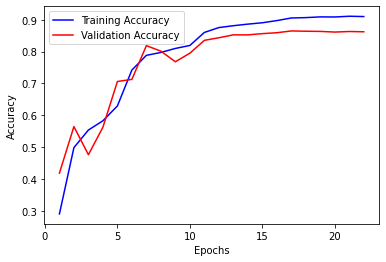

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       682
           1       0.96      0.97      0.96       627
           2       0.68      0.72      0.70       590
           3       0.98      1.00      0.99       449
           4       0.94      0.87      0.91       311
           5       0.65      0.60      0.63       302
           6       0.82      0.83      0.83       222
           7       0.79      0.78      0.79       236

    accuracy                           0.86      3419
   macro avg       0.85      0.84      0.84      3419
weighted avg       0.87      0.86      0.86      3419



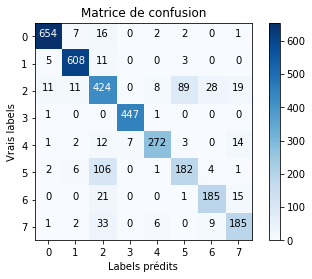

Durée : 1129.269 sec


In [65]:
my_CNN_TL(data_df, 60, "kmeansXYRGB", "VGG16")

##### Equalizer

In [9]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_equalizer.parquet')

Epoch 1/30


2022-01-19 12:59:49.856843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 2.1381 - accuracy: 0.1806

2022-01-19 13:00:33.646447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 50s 149ms/step - loss: 2.1379 - accuracy: 0.1806 - val_loss: 2.0188 - val_accuracy: 0.1922
Epoch 2/30
321/321 [==============================] - 48s 149ms/step - loss: 2.0150 - accuracy: 0.1815 - val_loss: 2.0138 - val_accuracy: 0.1743
Epoch 3/30
321/321 [==============================] - 48s 151ms/step - loss: 2.0129 - accuracy: 0.1772 - val_loss: 2.0131 - val_accuracy: 0.1922
Epoch 4/30
321/321 [==============================] - 48s 149ms/step - loss: 2.0105 - accuracy: 0.1828 - val_loss: 2.0115 - val_accuracy: 0.1922

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/30
321/321 [==============================] - 48s 150ms/step - loss: 2.0042 - accuracy: 0.1908 - val_loss: 2.0105 - val_accuracy: 0.1922
Epoch 6/30
321/321 [==============================] - 50s 154ms/step - loss: 2.0002 - accuracy: 0.1945 - val_loss: 2.0052 - val_accuracy: 0.1922
Epoch 7/30
321/321 [==============================] - 49s 1

2022-01-19 13:20:36.872379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


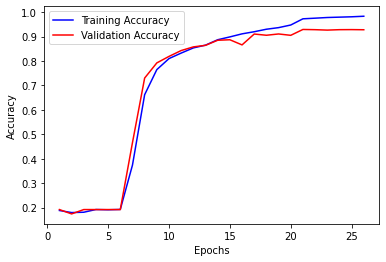

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       682
           1       0.99      0.99      0.99       627
           2       0.89      0.85      0.87       590
           3       0.98      0.99      0.99       449
           4       0.94      0.88      0.91       311
           5       0.83      0.89      0.86       302
           6       0.80      0.81      0.81       222
           7       0.91      0.95      0.93       236

    accuracy                           0.93      3419
   macro avg       0.91      0.92      0.92      3419
weighted avg       0.93      0.93      0.93      3419



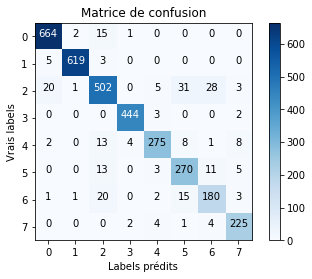

Durée : 1276.825 sec


In [11]:
my_CNN_TL(data_df, 60, "equalizer", "VGG16")

##### Mean Shift

In [6]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_mean_shift.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 00:45:02.370226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 2.2009 - accuracy: 0.1988

2022-01-19 00:45:52.543038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 57s 165ms/step - loss: 2.1998 - accuracy: 0.1990 - val_loss: 1.2907 - val_accuracy: 0.4794
Epoch 2/30
321/321 [==============================] - 51s 158ms/step - loss: 1.1308 - accuracy: 0.5586 - val_loss: 0.7849 - val_accuracy: 0.6897
Epoch 3/30
321/321 [==============================] - 49s 153ms/step - loss: 0.7847 - accuracy: 0.6963 - val_loss: 0.7128 - val_accuracy: 0.7233
Epoch 4/30
321/321 [==============================] - 50s 155ms/step - loss: 0.6414 - accuracy: 0.7511 - val_loss: 0.6078 - val_accuracy: 0.7464
Epoch 5/30
321/321 [==============================] - 50s 155ms/step - loss: 0.6056 - accuracy: 0.7632 - val_loss: 0.7138 - val_accuracy: 0.7271
Epoch 6/30
321/321 [==============================] - 49s 153ms/step - loss: 0.5804 - accuracy: 0.7833 - val_loss: 0.5092 - val_accuracy: 0.8099
Epoch 7/30
321/321 [==============================] - 49s 154ms/step - loss: 0.5363 - accuracy: 0.8037 - val_loss: 0.5986 - val_accuracy: 0.7

2022-01-19 00:59:13.589470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


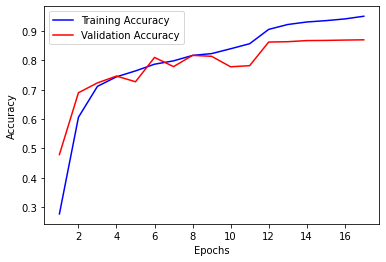

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       682
           1       0.91      0.93      0.92       627
           2       0.72      0.83      0.77       590
           3       1.00      1.00      1.00       449
           4       0.96      0.88      0.92       311
           5       0.78      0.53      0.63       302
           6       0.77      0.86      0.81       222
           7       0.88      0.87      0.88       236

    accuracy                           0.88      3419
   macro avg       0.87      0.86      0.86      3419
weighted avg       0.88      0.88      0.87      3419



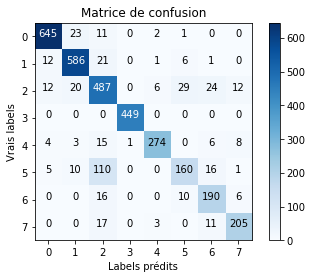

Durée : 894.639 sec


In [75]:
my_CNN_TL(data_df, 60, "mean_shift", "VGG16")

##### Gray

In [10]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_gray.parquet')

In [ ]:
my_CNN_TL(data_df, 60, "gray", "VGG16")

##### LAB

In [34]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_lab.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 09:20:54.966791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.9022 - accuracy: 0.2598

2022-01-19 09:21:38.964646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 50s 148ms/step - loss: 1.9013 - accuracy: 0.2602 - val_loss: 1.2846 - val_accuracy: 0.4797
Epoch 2/30
321/321 [==============================] - 46s 144ms/step - loss: 1.1565 - accuracy: 0.5515 - val_loss: 1.0149 - val_accuracy: 0.6312
Epoch 3/30
321/321 [==============================] - 46s 144ms/step - loss: 0.9821 - accuracy: 0.6439 - val_loss: 0.7480 - val_accuracy: 0.7145
Epoch 4/30
321/321 [==============================] - 46s 144ms/step - loss: 0.7475 - accuracy: 0.7230 - val_loss: 0.7185 - val_accuracy: 0.7148
Epoch 5/30
321/321 [==============================] - 46s 144ms/step - loss: 0.6580 - accuracy: 0.7542 - val_loss: 0.6335 - val_accuracy: 0.7619
Epoch 6/30
321/321 [==============================] - 46s 144ms/step - loss: 0.5998 - accuracy: 0.7688 - val_loss: 0.7987 - val_accuracy: 0.7192
Epoch 7/30
321/321 [==============================] - 46s 145ms/step - loss: 0.5800 - accuracy: 0.7805 - val_loss: 0.9893 - val_accuracy: 0.7

2022-01-19 09:36:22.962398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


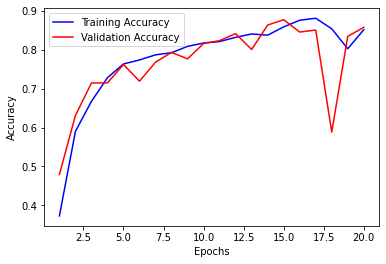

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       667
           1       0.94      0.94      0.94       639
           2       0.66      0.78      0.72       589
           3       1.00      0.99      0.99       449
           4       0.93      0.79      0.86       311
           5       0.64      0.58      0.61       289
           6       0.78      0.77      0.78       222
           7       0.87      0.86      0.86       253

    accuracy                           0.85      3419
   macro avg       0.84      0.83      0.83      3419
weighted avg       0.86      0.85      0.85      3419



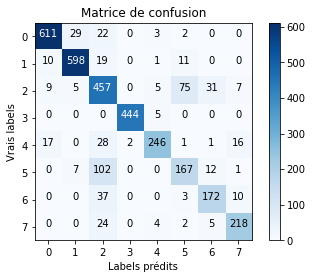

Durée : 958.53 sec


In [23]:
my_CNN_TL(data_df, 60, "lab", "VGG16")

##### Canny

In [ ]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_canny.parquet')

In [ ]:
my_CNN_TL(data_df, 60, "canny", "VGG16")

##### Otsu

In [ ]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_otsu.parquet')

In [ ]:
my_CNN_TL(data_df, 60, "otsu", "VGG16")

##### Otsu_canny

In [ ]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_otsu_canny.parquet')

In [ ]:
my_CNN_TL(data_df, 60, "otsu_canny", "VGG16")

##### Threshold_color --> Gray

In [ ]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_threshold_color_g.parquet')

In [ ]:
my_CNN_TL(data_df, 60, "threshold_color_g", "VGG16")

##### Kmeans1

In [17]:
data_df, load_time = load_dataset('dataset_all_img__s_60x60__f_kmeans1.parquet')

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 08:23:16.032544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 2.0258 - accuracy: 0.2336

2022-01-19 08:24:00.622981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 50s 152ms/step - loss: 2.0249 - accuracy: 0.2339 - val_loss: 1.2190 - val_accuracy: 0.5373
Epoch 2/30
321/321 [==============================] - 48s 149ms/step - loss: 1.1410 - accuracy: 0.5612 - val_loss: 0.8410 - val_accuracy: 0.6753
Epoch 3/30
321/321 [==============================] - 48s 149ms/step - loss: 0.7826 - accuracy: 0.7079 - val_loss: 0.9486 - val_accuracy: 0.6303
Epoch 4/30
321/321 [==============================] - 48s 148ms/step - loss: 0.6945 - accuracy: 0.7367 - val_loss: 0.8242 - val_accuracy: 0.7195
Epoch 5/30
321/321 [==============================] - 47s 148ms/step - loss: 0.6395 - accuracy: 0.7584 - val_loss: 0.5718 - val_accuracy: 0.7736
Epoch 6/30
321/321 [==============================] - 47s 148ms/step - loss: 0.5650 - accuracy: 0.7871 - val_loss: 0.5404 - val_accuracy: 0.7818
Epoch 7/30
321/321 [==============================] - 48s 148ms/step - loss: 0.5424 - accuracy: 0.7909 - val_loss: 0.6002 - val_accuracy: 0.7

2022-01-19 08:34:23.571067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


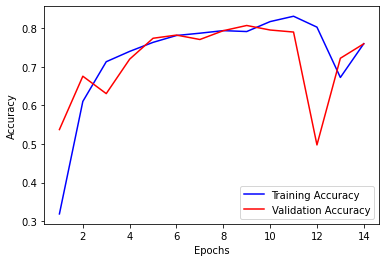

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       667
           1       0.74      0.85      0.79       639
           2       0.57      0.73      0.64       589
           3       0.98      0.96      0.97       449
           4       0.90      0.74      0.81       311
           5       0.48      0.07      0.13       289
           6       0.61      0.67      0.64       222
           7       0.78      0.68      0.73       253

    accuracy                           0.76      3419
   macro avg       0.74      0.70      0.70      3419
weighted avg       0.75      0.76      0.74      3419



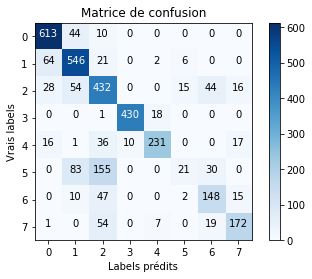

Durée : 702.244 sec


In [18]:
my_CNN_TL(data_df, 60, "kmeans1", "VGG16")

## TL VGG19

##### rgb

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 17:53:10.409420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 2.1724 - accuracy: 0.1772

2022-01-18 17:53:56.740895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 53s 152ms/step - loss: 2.1720 - accuracy: 0.1772 - val_loss: 1.8317 - val_accuracy: 0.2899
Epoch 2/30
321/321 [==============================] - 48s 149ms/step - loss: 1.3601 - accuracy: 0.4809 - val_loss: 1.0034 - val_accuracy: 0.6321
Epoch 3/30
321/321 [==============================] - 48s 149ms/step - loss: 0.9834 - accuracy: 0.6477 - val_loss: 0.9374 - val_accuracy: 0.6408
Epoch 4/30
321/321 [==============================] - 48s 149ms/step - loss: 0.8516 - accuracy: 0.6811 - val_loss: 0.6090 - val_accuracy: 0.7669
Epoch 5/30
321/321 [==============================] - 47s 148ms/step - loss: 0.5994 - accuracy: 0.7624 - val_loss: 0.4657 - val_accuracy: 0.7956
Epoch 6/30
321/321 [==============================] - 48s 149ms/step - loss: 0.5719 - accuracy: 0.7784 - val_loss: 0.5491 - val_accuracy: 0.8002
Epoch 7/30
321/321 [==============================] - 47s 148ms/step - loss: 0.4546 - accuracy: 0.8323 - val_loss: 0.3558 - val_accuracy: 0.8

2022-01-18 18:11:27.350140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


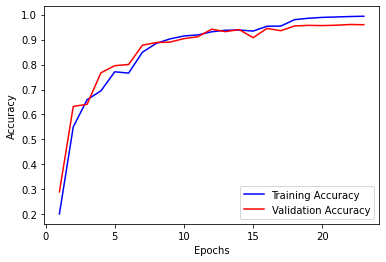

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       667
           1       1.00      1.00      1.00       639
           2       0.90      0.89      0.90       589
           3       1.00      1.00      1.00       449
           4       0.96      0.94      0.95       311
           5       0.85      0.93      0.89       289
           6       0.96      0.86      0.91       222
           7       0.96      0.96      0.96       253

    accuracy                           0.95      3419
   macro avg       0.95      0.94      0.95      3419
weighted avg       0.95      0.95      0.95      3419



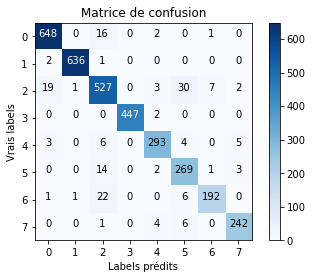

Durée : 1144.361 sec


In [46]:
my_CNN_TL(data_df, 60, "rgb", "VGG16")

##### HSV

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 19:15:34.651583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 2.0604 - accuracy: 0.2477

2022-01-18 19:16:31.551390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 64s 193ms/step - loss: 2.0596 - accuracy: 0.2479 - val_loss: 1.3550 - val_accuracy: 0.4162
Epoch 2/30
321/321 [==============================] - 57s 177ms/step - loss: 1.2779 - accuracy: 0.4831 - val_loss: 0.9818 - val_accuracy: 0.6113
Epoch 3/30
321/321 [==============================] - 59s 183ms/step - loss: 1.0024 - accuracy: 0.6085 - val_loss: 0.8676 - val_accuracy: 0.6803
Epoch 4/30
321/321 [==============================] - 58s 181ms/step - loss: 1.0275 - accuracy: 0.6207 - val_loss: 0.9707 - val_accuracy: 0.6362
Epoch 5/30
321/321 [==============================] - 58s 180ms/step - loss: 0.9650 - accuracy: 0.6370 - val_loss: 1.7458 - val_accuracy: 0.3141
Epoch 6/30
321/321 [==============================] - 58s 179ms/step - loss: 1.5464 - accuracy: 0.3981 - val_loss: 1.0050 - val_accuracy: 0.6092

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
321/321 [==============================] - 58s 1

2022-01-18 19:44:32.488340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


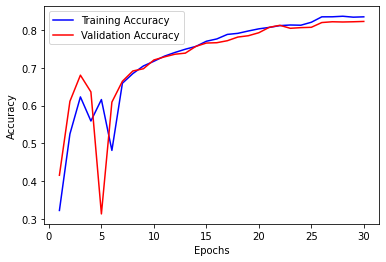

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       667
           1       0.93      0.92      0.93       639
           2       0.63      0.76      0.69       589
           3       1.00      0.99      0.99       449
           4       0.93      0.79      0.85       311
           5       0.60      0.46      0.52       289
           6       0.65      0.59      0.62       222
           7       0.80      0.87      0.83       253

    accuracy                           0.83      3419
   macro avg       0.81      0.79      0.80      3419
weighted avg       0.83      0.83      0.83      3419



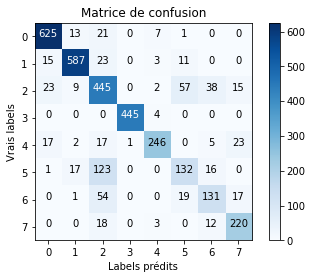

Durée : 1769.316 sec


In [51]:
my_CNN_TL(data_df, 60, "hsv", "VGG19")

##### Threshold Color

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 11:17:31.670417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.8508 - accuracy: 0.2955

2022-01-19 11:18:26.638540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 62s 188ms/step - loss: 1.8500 - accuracy: 0.2958 - val_loss: 1.1231 - val_accuracy: 0.5437
Epoch 2/30
321/321 [==============================] - 58s 181ms/step - loss: 1.1350 - accuracy: 0.5581 - val_loss: 1.0010 - val_accuracy: 0.6049
Epoch 3/30
321/321 [==============================] - 58s 180ms/step - loss: 1.0463 - accuracy: 0.5744 - val_loss: 0.9898 - val_accuracy: 0.5847
Epoch 4/30
321/321 [==============================] - 58s 180ms/step - loss: 0.9456 - accuracy: 0.6148 - val_loss: 0.9338 - val_accuracy: 0.6171
Epoch 5/30
321/321 [==============================] - 58s 180ms/step - loss: 0.9299 - accuracy: 0.6330 - val_loss: 0.8720 - val_accuracy: 0.6247
Epoch 6/30
321/321 [==============================] - 60s 186ms/step - loss: 0.8434 - accuracy: 0.6671 - val_loss: 0.8415 - val_accuracy: 0.6666
Epoch 7/30
321/321 [==============================] - 59s 183ms/step - loss: 0.8842 - accuracy: 0.6603 - val_loss: 0.8428 - val_accuracy: 0.6

2022-01-19 11:35:12.071491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


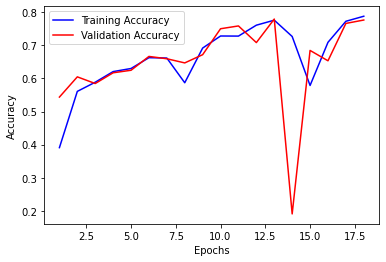

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       667
           1       0.81      0.84      0.82       639
           2       0.57      0.81      0.67       589
           3       1.00      0.97      0.98       449
           4       0.89      0.87      0.88       311
           5       0.58      0.11      0.18       289
           6       0.73      0.77      0.75       222
           7       0.82      0.80      0.81       253

    accuracy                           0.78      3419
   macro avg       0.78      0.75      0.74      3419
weighted avg       0.78      0.78      0.76      3419



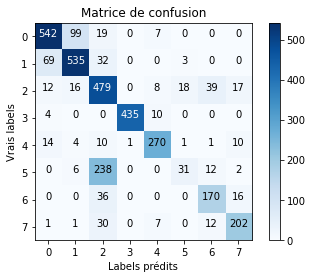

Durée : 1092.453 sec


In [33]:
my_CNN_TL(data_df, 60, "threshold_color", "VGG19")

##### Kmeans 2

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 21:36:36.663756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.8124 - accuracy: 0.3029

2022-01-18 21:37:33.763387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 65s 196ms/step - loss: 1.8116 - accuracy: 0.3032 - val_loss: 1.3358 - val_accuracy: 0.4770
Epoch 2/30
321/321 [==============================] - 60s 186ms/step - loss: 0.9613 - accuracy: 0.6270 - val_loss: 0.7978 - val_accuracy: 0.7365
Epoch 3/30
321/321 [==============================] - 58s 180ms/step - loss: 0.7537 - accuracy: 0.7243 - val_loss: 0.6370 - val_accuracy: 0.7637
Epoch 4/30
321/321 [==============================] - 58s 182ms/step - loss: 0.5822 - accuracy: 0.7739 - val_loss: 0.5813 - val_accuracy: 0.7754
Epoch 5/30
321/321 [==============================] - 58s 181ms/step - loss: 0.5199 - accuracy: 0.8023 - val_loss: 0.4532 - val_accuracy: 0.8154
Epoch 6/30
321/321 [==============================] - 58s 181ms/step - loss: 0.4651 - accuracy: 0.8239 - val_loss: 0.4475 - val_accuracy: 0.8538
Epoch 7/30
321/321 [==============================] - 58s 181ms/step - loss: 0.4205 - accuracy: 0.8497 - val_loss: 0.5972 - val_accuracy: 0.7

2022-01-18 21:53:13.332517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


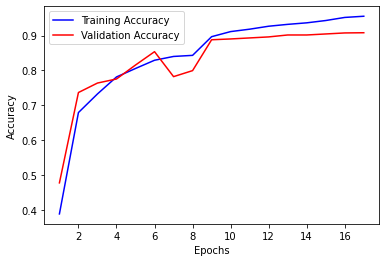

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       667
           1       0.96      0.94      0.95       639
           2       0.76      0.84      0.80       589
           3       1.00      1.00      1.00       449
           4       0.93      0.89      0.91       311
           5       0.84      0.76      0.80       289
           6       0.88      0.87      0.87       222
           7       0.88      0.87      0.87       253

    accuracy                           0.90      3419
   macro avg       0.90      0.89      0.89      3419
weighted avg       0.91      0.90      0.90      3419



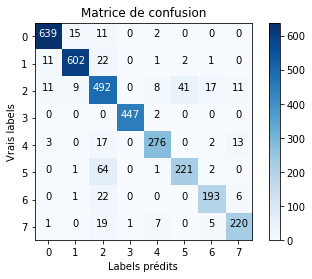

Durée : 1030.085 sec


In [61]:
my_CNN_TL(data_df, 60, "kmeans2", "VGG19")

##### Kmeans XYRGB

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 22:49:37.585121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.9657 - accuracy: 0.2666

2022-01-18 22:50:38.927545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 70s 205ms/step - loss: 1.9649 - accuracy: 0.2668 - val_loss: 1.2006 - val_accuracy: 0.5592
Epoch 2/30
321/321 [==============================] - 60s 185ms/step - loss: 1.2193 - accuracy: 0.5297 - val_loss: 1.0560 - val_accuracy: 0.6016
Epoch 3/30
321/321 [==============================] - 60s 187ms/step - loss: 1.0862 - accuracy: 0.5943 - val_loss: 0.9724 - val_accuracy: 0.6347
Epoch 4/30
321/321 [==============================] - 60s 186ms/step - loss: 1.0638 - accuracy: 0.6112 - val_loss: 1.1864 - val_accuracy: 0.5703
Epoch 5/30
321/321 [==============================] - 60s 186ms/step - loss: 0.9560 - accuracy: 0.6563 - val_loss: 0.7073 - val_accuracy: 0.7318
Epoch 6/30
321/321 [==============================] - 60s 186ms/step - loss: 0.7128 - accuracy: 0.7333 - val_loss: 0.7655 - val_accuracy: 0.7020
Epoch 7/30
321/321 [==============================] - 60s 187ms/step - loss: 0.6318 - accuracy: 0.7658 - val_loss: 0.6087 - val_accuracy: 0.7

2022-01-18 23:12:33.603269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


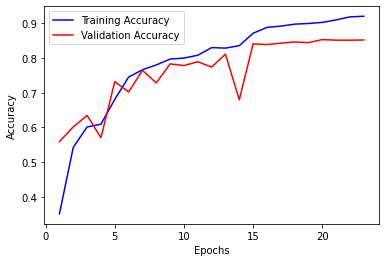

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       682
           1       0.97      0.96      0.97       627
           2       0.69      0.70      0.70       590
           3       0.98      0.99      0.99       449
           4       0.93      0.84      0.88       311
           5       0.65      0.63      0.64       302
           6       0.80      0.88      0.84       222
           7       0.80      0.78      0.79       236

    accuracy                           0.86      3419
   macro avg       0.85      0.84      0.84      3419
weighted avg       0.86      0.86      0.86      3419



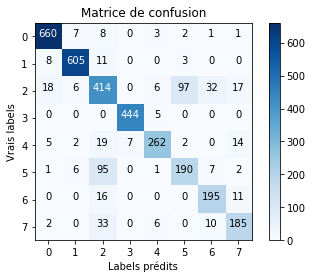

Durée : 1432.035 sec


In [66]:
my_CNN_TL(data_df, 60, "kmeansXYRGB", "VGG19")

##### Equalizer

Epoch 1/30


2022-01-19 12:15:56.962453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 5.7903 - accuracy: 0.1770

2022-01-19 12:16:50.824650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 61s 186ms/step - loss: 5.7808 - accuracy: 0.1770 - val_loss: 2.0192 - val_accuracy: 0.1743
Epoch 2/30
321/321 [==============================] - 59s 185ms/step - loss: 2.0142 - accuracy: 0.1900 - val_loss: 2.0140 - val_accuracy: 0.1743
Epoch 3/30
321/321 [==============================] - 60s 185ms/step - loss: 2.0050 - accuracy: 0.2000 - val_loss: 2.0120 - val_accuracy: 0.1743
Epoch 4/30
321/321 [==============================] - 59s 185ms/step - loss: 2.0120 - accuracy: 0.1909 - val_loss: 2.0168 - val_accuracy: 0.1922

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/30
321/321 [==============================] - 60s 187ms/step - loss: 2.0023 - accuracy: 0.1898 - val_loss: 2.0111 - val_accuracy: 0.1922
Epoch 6/30
321/321 [==============================] - 60s 186ms/step - loss: 2.0073 - accuracy: 0.1984 - val_loss: 2.0073 - val_accuracy: 0.2056
Epoch 7/30
321/321 [==============================] - 59s 1

2022-01-19 12:45:29.847885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


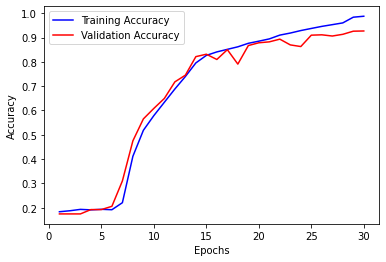

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       682
           1       0.99      0.99      0.99       627
           2       0.90      0.89      0.89       590
           3       0.97      0.99      0.98       449
           4       0.89      0.89      0.89       311
           5       0.90      0.84      0.87       302
           6       0.87      0.89      0.88       222
           7       0.91      0.93      0.92       236

    accuracy                           0.94      3419
   macro avg       0.92      0.92      0.92      3419
weighted avg       0.94      0.94      0.94      3419



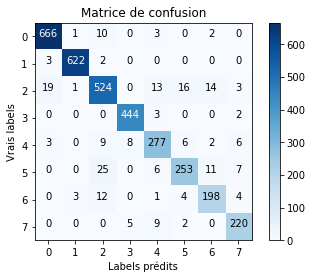

Durée : 1798.394 sec


In [8]:
my_CNN_TL(data_df, 60, "equalizer", "VGG19")

##### Mean Shift

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Metal device set to: Apple M1


2022-01-19 01:11:13.284192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-19 01:11:13.284912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-19 01:11:14.556531: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-19 01:11:14.560047: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-01-19 01:11:23.053543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.9229 - accuracy: 0.2612

2022-01-19 01:12:17.407718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 69s 187ms/step - loss: 1.9219 - accuracy: 0.2616 - val_loss: 1.8190 - val_accuracy: 0.3326
Epoch 2/30
321/321 [==============================] - 59s 184ms/step - loss: 1.1676 - accuracy: 0.5532 - val_loss: 1.0271 - val_accuracy: 0.5911
Epoch 3/30
321/321 [==============================] - 59s 183ms/step - loss: 1.0329 - accuracy: 0.6045 - val_loss: 1.0013 - val_accuracy: 0.6288
Epoch 4/30
321/321 [==============================] - 58s 180ms/step - loss: 0.9464 - accuracy: 0.6448 - val_loss: 0.9674 - val_accuracy: 0.6476
Epoch 5/30
321/321 [==============================] - 58s 179ms/step - loss: 0.8323 - accuracy: 0.7016 - val_loss: 0.7581 - val_accuracy: 0.7227
Epoch 6/30
321/321 [==============================] - 58s 179ms/step - loss: 0.7848 - accuracy: 0.7188 - val_loss: 0.8358 - val_accuracy: 0.6920
Epoch 7/30
321/321 [==============================] - 57s 179ms/step - loss: 0.7715 - accuracy: 0.7247 - val_loss: 0.8605 - val_accuracy: 0.6

2022-01-19 01:32:26.570453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


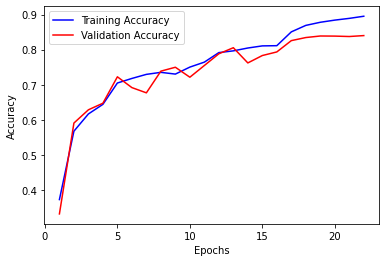

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       682
           1       0.86      0.92      0.89       627
           2       0.71      0.76      0.73       590
           3       1.00      0.98      0.99       449
           4       0.94      0.87      0.90       311
           5       0.66      0.54      0.59       302
           6       0.71      0.76      0.74       222
           7       0.87      0.85      0.86       236

    accuracy                           0.85      3419
   macro avg       0.84      0.83      0.83      3419
weighted avg       0.85      0.85      0.85      3419



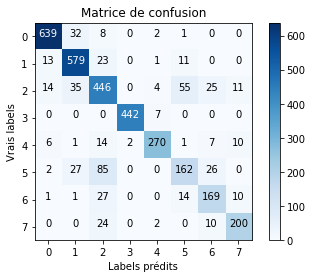

Durée : 1295.767 sec


In [7]:
my_CNN_TL(data_df, 60, "mean_shift", "VGG19")

##### Gray

In [ ]:
my_CNN_TL(data_df, 60, "gray", "VGG19")

##### LAB

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 09:36:54.823964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 2.6490 - accuracy: 0.1785

2022-01-19 09:37:48.742955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 64s 183ms/step - loss: 2.6474 - accuracy: 0.1785 - val_loss: 2.0128 - val_accuracy: 0.1887
Epoch 2/30
321/321 [==============================] - 57s 177ms/step - loss: 2.0079 - accuracy: 0.1960 - val_loss: 2.0160 - val_accuracy: 0.1872
Epoch 3/30
321/321 [==============================] - 56s 175ms/step - loss: 2.0198 - accuracy: 0.1856 - val_loss: 2.0125 - val_accuracy: 0.1887
Epoch 4/30
321/321 [==============================] - 56s 175ms/step - loss: 2.0196 - accuracy: 0.1835 - val_loss: 2.0175 - val_accuracy: 0.1887

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/30
321/321 [==============================] - 56s 175ms/step - loss: 2.0116 - accuracy: 0.1958 - val_loss: 2.0092 - val_accuracy: 0.1887
Epoch 6/30
321/321 [==============================] - 56s 175ms/step - loss: 2.0003 - accuracy: 0.1903 - val_loss: 1.9310 - val_accuracy: 0.3039
Epoch 7/30
321/321 [==============================] - 56s 1

2022-01-19 09:59:28.699425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


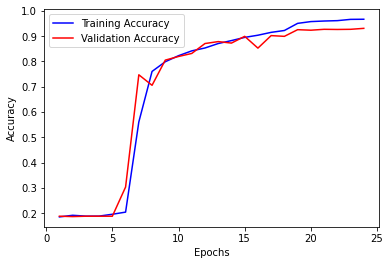

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       667
           1       0.99      0.98      0.98       639
           2       0.82      0.85      0.83       589
           3       1.00      1.00      1.00       449
           4       0.97      0.95      0.96       311
           5       0.79      0.82      0.80       289
           6       0.95      0.91      0.93       222
           7       0.96      0.92      0.94       253

    accuracy                           0.93      3419
   macro avg       0.93      0.92      0.93      3419
weighted avg       0.93      0.93      0.93      3419



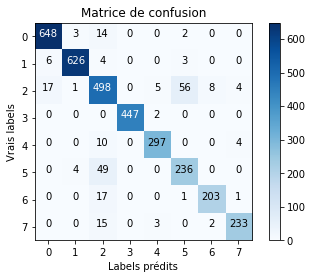

Durée : 1385.798 sec


In [24]:
my_CNN_TL(data_df, 60, "lab", "VGG19")

##### Canny

In [ ]:
my_CNN_TL(data_df, 60, "canny", "VGG19")

##### Otsu

In [ ]:
my_CNN_TL(data_df, 60, "otsu", "VGG19")

##### Otsu_canny

In [ ]:
my_CNN_TL(data_df, 60, "otsu_canny", "VGG19")

##### Threshold_color --> Gray

In [ ]:
my_CNN_TL(data_df, 60, "threshold_color_g", "VGG19")

##### Kmeans1

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 08:34:56.532640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 2.2147 - accuracy: 0.1932

2022-01-19 08:35:55.405041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 66s 201ms/step - loss: 2.2139 - accuracy: 0.1934 - val_loss: 1.7097 - val_accuracy: 0.3963
Epoch 2/30
321/321 [==============================] - 57s 176ms/step - loss: 1.4090 - accuracy: 0.4140 - val_loss: 1.2435 - val_accuracy: 0.4744
Epoch 3/30
321/321 [==============================] - 56s 175ms/step - loss: 1.0709 - accuracy: 0.6005 - val_loss: 0.9838 - val_accuracy: 0.6329
Epoch 4/30
321/321 [==============================] - 56s 175ms/step - loss: 0.8500 - accuracy: 0.6951 - val_loss: 0.7669 - val_accuracy: 0.7172
Epoch 5/30
321/321 [==============================] - 56s 175ms/step - loss: 0.7823 - accuracy: 0.7211 - val_loss: 0.7160 - val_accuracy: 0.7227
Epoch 6/30
321/321 [==============================] - 56s 176ms/step - loss: 0.7605 - accuracy: 0.7129 - val_loss: 0.6712 - val_accuracy: 0.7412
Epoch 7/30
321/321 [==============================] - 56s 175ms/step - loss: 0.6250 - accuracy: 0.7529 - val_loss: 0.6655 - val_accuracy: 0.7

2022-01-19 08:53:49.184972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


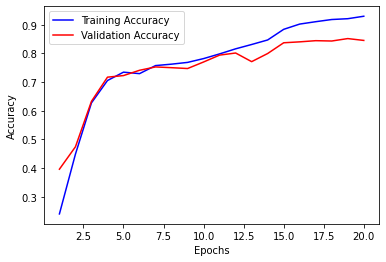

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       667
           1       0.95      0.92      0.94       639
           2       0.76      0.69      0.73       589
           3       0.99      0.99      0.99       449
           4       0.94      0.88      0.91       311
           5       0.52      0.62      0.57       289
           6       0.71      0.73      0.72       222
           7       0.87      0.84      0.85       253

    accuracy                           0.85      3419
   macro avg       0.83      0.83      0.83      3419
weighted avg       0.86      0.85      0.85      3419



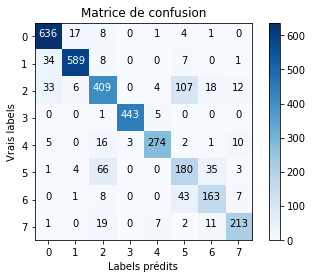

Durée : 1164.414 sec


In [19]:
my_CNN_TL(data_df, 60, "kmeans1", "VGG19")

## TL ResNet50

##### RGB

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 18:12:11.142324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.4014 - accuracy: 0.5231

2022-01-18 18:12:57.078838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 57s 154ms/step - loss: 1.4004 - accuracy: 0.5233 - val_loss: 3.0668 - val_accuracy: 0.2574
Epoch 2/30
321/321 [==============================] - 50s 156ms/step - loss: 0.7690 - accuracy: 0.7195 - val_loss: 6.6396 - val_accuracy: 0.1971
Epoch 3/30
321/321 [==============================] - 49s 151ms/step - loss: 0.6143 - accuracy: 0.7721 - val_loss: 1.2641 - val_accuracy: 0.5540
Epoch 4/30
321/321 [==============================] - 48s 151ms/step - loss: 0.5665 - accuracy: 0.8046 - val_loss: 6.3745 - val_accuracy: 0.2624
Epoch 5/30
321/321 [==============================] - 49s 151ms/step - loss: 0.5816 - accuracy: 0.7958 - val_loss: 6.7014 - val_accuracy: 0.1281
Epoch 6/30
321/321 [==============================] - 51s 160ms/step - loss: 0.6188 - accuracy: 0.7845 - val_loss: 2.4844 - val_accuracy: 0.4832

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
321/321 [==============================] - 50s 1

2022-01-18 18:27:02.998141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


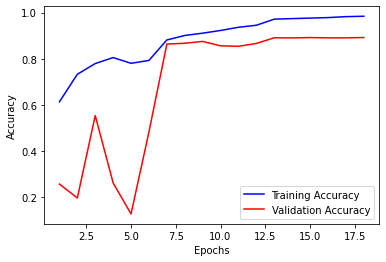

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       667
           1       0.92      0.92      0.92       639
           2       0.81      0.85      0.83       589
           3       1.00      0.99      0.99       449
           4       0.92      0.89      0.91       311
           5       0.79      0.70      0.74       289
           6       0.81      0.89      0.85       222
           7       0.90      0.94      0.92       253

    accuracy                           0.90      3419
   macro avg       0.89      0.89      0.89      3419
weighted avg       0.90      0.90      0.90      3419



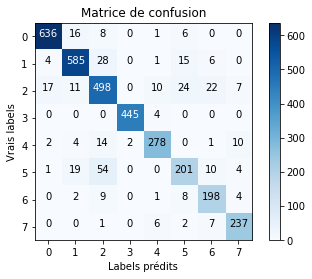

Durée : 935.349 sec


In [47]:
my_CNN_TL(data_df, 60, "rgb", "ResNet50")

##### HSV

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 19:45:09.169266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.2950 - accuracy: 0.5465

2022-01-18 19:46:00.887043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 63s 171ms/step - loss: 1.2941 - accuracy: 0.5468 - val_loss: 6.7157 - val_accuracy: 0.1351
Epoch 2/30
321/321 [==============================] - 55s 169ms/step - loss: 0.8129 - accuracy: 0.6928 - val_loss: 2.1502 - val_accuracy: 0.4346
Epoch 3/30
321/321 [==============================] - 50s 154ms/step - loss: 0.6850 - accuracy: 0.7450 - val_loss: 6.4742 - val_accuracy: 0.0772
Epoch 4/30
321/321 [==============================] - 49s 153ms/step - loss: 0.6034 - accuracy: 0.7833 - val_loss: 5.2885 - val_accuracy: 0.1579
Epoch 5/30
321/321 [==============================] - 49s 152ms/step - loss: 0.5396 - accuracy: 0.8036 - val_loss: 9.6787 - val_accuracy: 0.1424

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/30
321/321 [==============================] - 49s 152ms/step - loss: 0.4156 - accuracy: 0.8536 - val_loss: 0.6693 - val_accuracy: 0.7710
Epoch 7/30
321/321 [==============================] - 49s 1

2022-01-18 20:00:14.256097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


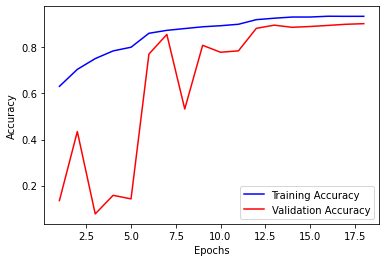

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       667
           1       0.95      0.96      0.96       639
           2       0.82      0.81      0.81       589
           3       1.00      0.98      0.99       449
           4       0.91      0.86      0.88       311
           5       0.84      0.76      0.80       289
           6       0.81      0.82      0.82       222
           7       0.89      0.92      0.90       253

    accuracy                           0.90      3419
   macro avg       0.89      0.89      0.89      3419
weighted avg       0.90      0.90      0.90      3419



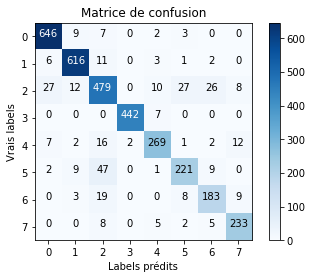

Durée : 939.263 sec


In [52]:
my_CNN_TL(data_df, 60, "hsv", "ResNet50")

##### Threshold Color

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 20:53:44.282800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.1992 - accuracy: 0.5752

2022-01-18 20:54:41.233754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 73s 187ms/step - loss: 1.1984 - accuracy: 0.5754 - val_loss: 1.8269 - val_accuracy: 0.4235
Epoch 2/30
321/321 [==============================] - 58s 177ms/step - loss: 0.7996 - accuracy: 0.7042 - val_loss: 1.7307 - val_accuracy: 0.5741
Epoch 3/30
321/321 [==============================] - 50s 156ms/step - loss: 0.6068 - accuracy: 0.7715 - val_loss: 3.0202 - val_accuracy: 0.3366
Epoch 4/30
321/321 [==============================] - 56s 173ms/step - loss: 0.6354 - accuracy: 0.7777 - val_loss: 2.1506 - val_accuracy: 0.3788
Epoch 5/30
321/321 [==============================] - 50s 156ms/step - loss: 0.5152 - accuracy: 0.8122 - val_loss: 1.7943 - val_accuracy: 0.4829

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/30
321/321 [==============================] - 50s 155ms/step - loss: 0.3780 - accuracy: 0.8618 - val_loss: 0.6259 - val_accuracy: 0.7675
Epoch 7/30
321/321 [==============================] - 50s 1

2022-01-18 21:04:12.119075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


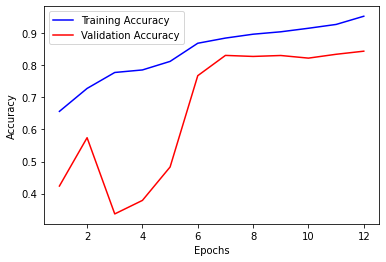

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       667
           1       0.85      0.82      0.83       639
           2       0.74      0.79      0.76       589
           3       0.98      0.99      0.98       449
           4       0.90      0.91      0.90       311
           5       0.77      0.76      0.77       289
           6       0.87      0.84      0.85       222
           7       0.91      0.85      0.88       253

    accuracy                           0.86      3419
   macro avg       0.86      0.86      0.86      3419
weighted avg       0.86      0.86      0.86      3419



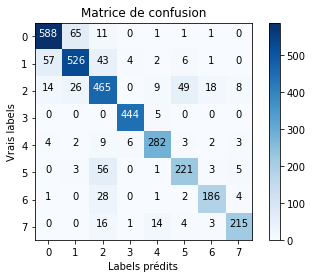

Durée : 664.011 sec


In [57]:
my_CNN_TL(data_df, 60, "threshold_color", "ResNet50")

##### Kmeans2

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 21:53:48.973873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.3426 - accuracy: 0.5462

2022-01-18 21:54:41.294305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 64s 175ms/step - loss: 1.3418 - accuracy: 0.5464 - val_loss: 1.4492 - val_accuracy: 0.6201
Epoch 2/30
321/321 [==============================] - 52s 159ms/step - loss: 0.8208 - accuracy: 0.6988 - val_loss: 2.5613 - val_accuracy: 0.4674
Epoch 3/30
321/321 [==============================] - 53s 162ms/step - loss: 0.6297 - accuracy: 0.7696 - val_loss: 2.4390 - val_accuracy: 0.3688
Epoch 4/30
321/321 [==============================] - 52s 161ms/step - loss: 0.6638 - accuracy: 0.7664 - val_loss: 0.7388 - val_accuracy: 0.7110
Epoch 5/30
321/321 [==============================] - 51s 160ms/step - loss: 0.4923 - accuracy: 0.8267 - val_loss: 4.7460 - val_accuracy: 0.1182
Epoch 6/30
321/321 [==============================] - 51s 157ms/step - loss: 0.4753 - accuracy: 0.8269 - val_loss: 2.2134 - val_accuracy: 0.6013
Epoch 7/30
321/321 [==============================] - 50s 156ms/step - loss: 0.4693 - accuracy: 0.8368 - val_loss: 1.1550 - val_accuracy: 0.6

2022-01-18 22:10:44.660891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


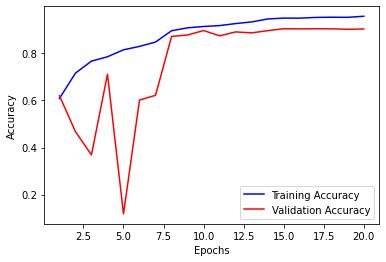

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       667
           1       0.94      0.95      0.95       639
           2       0.83      0.84      0.83       589
           3       0.98      0.99      0.98       449
           4       0.89      0.85      0.87       311
           5       0.83      0.83      0.83       289
           6       0.88      0.89      0.89       222
           7       0.86      0.89      0.88       253

    accuracy                           0.91      3419
   macro avg       0.90      0.90      0.90      3419
weighted avg       0.91      0.91      0.91      3419



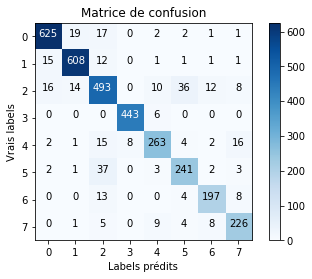

Durée : 1049.367 sec


In [62]:
my_CNN_TL(data_df, 60, "kmeans2", "ResNet50")

##### Kmeans XYRGB

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 23:13:45.084188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.5035 - accuracy: 0.4973

2022-01-18 23:14:50.082647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 88s 207ms/step - loss: 1.5025 - accuracy: 0.4975 - val_loss: 8.9503 - val_accuracy: 0.1357
Epoch 2/30
321/321 [==============================] - 53s 162ms/step - loss: 1.0092 - accuracy: 0.6300 - val_loss: 13.6211 - val_accuracy: 0.1419
Epoch 3/30
321/321 [==============================] - 57s 173ms/step - loss: 0.8010 - accuracy: 0.7048 - val_loss: 1.7968 - val_accuracy: 0.4493
Epoch 4/30
321/321 [==============================] - 53s 166ms/step - loss: 0.7142 - accuracy: 0.7394 - val_loss: 3.4589 - val_accuracy: 0.1392
Epoch 5/30
321/321 [==============================] - 52s 163ms/step - loss: 0.6833 - accuracy: 0.7456 - val_loss: 1.2765 - val_accuracy: 0.5276
Epoch 6/30
321/321 [==============================] - 53s 166ms/step - loss: 0.6169 - accuracy: 0.7731 - val_loss: 1.5299 - val_accuracy: 0.5347
Epoch 7/30
321/321 [==============================] - 51s 158ms/step - loss: 0.5846 - accuracy: 0.7863 - val_loss: 2.0419 - val_accuracy: 0.

2022-01-18 23:34:10.622931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


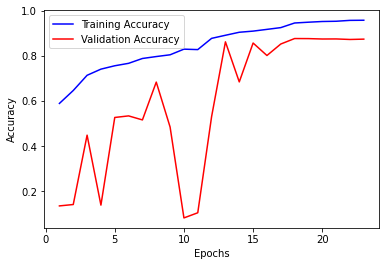

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       682
           1       0.96      0.92      0.94       627
           2       0.75      0.77      0.76       590
           3       0.97      0.99      0.98       449
           4       0.86      0.79      0.83       311
           5       0.72      0.72      0.72       302
           6       0.82      0.83      0.83       222
           7       0.79      0.84      0.81       236

    accuracy                           0.87      3419
   macro avg       0.85      0.85      0.85      3419
weighted avg       0.87      0.87      0.87      3419



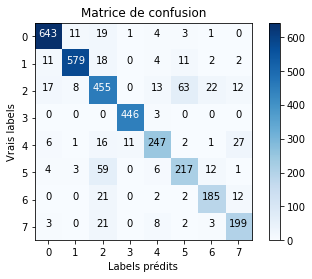

Durée : 1294.703 sec


In [67]:
my_CNN_TL(data_df, 60, "kmeansXYRGB", "ResNet50")

##### Equalizer

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 00:10:57.430705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.6370 - accuracy: 0.4617

2022-01-19 00:11:54.780191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 78s 190ms/step - loss: 1.6359 - accuracy: 0.4619 - val_loss: 1.2672 - val_accuracy: 0.5244
Epoch 2/30
321/321 [==============================] - 53s 164ms/step - loss: 0.9561 - accuracy: 0.6394 - val_loss: 2.0103 - val_accuracy: 0.3086
Epoch 3/30
321/321 [==============================] - 52s 162ms/step - loss: 0.8062 - accuracy: 0.7063 - val_loss: 5.5392 - val_accuracy: 0.2258
Epoch 4/30
321/321 [==============================] - 56s 176ms/step - loss: 0.6448 - accuracy: 0.7690 - val_loss: 2.7992 - val_accuracy: 0.2890

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/30
321/321 [==============================] - 65s 201ms/step - loss: 0.4264 - accuracy: 0.8489 - val_loss: 0.4544 - val_accuracy: 0.8327
Epoch 6/30
321/321 [==============================] - 61s 188ms/step - loss: 0.3346 - accuracy: 0.8789 - val_loss: 0.4746 - val_accuracy: 0.8280
Epoch 7/30
321/321 [==============================] - 53s 1

2022-01-19 00:26:01.595708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


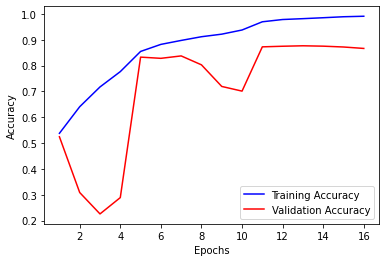

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       682
           1       0.97      0.95      0.96       627
           2       0.82      0.80      0.81       590
           3       0.92      0.96      0.94       449
           4       0.72      0.75      0.73       311
           5       0.76      0.80      0.78       302
           6       0.84      0.75      0.79       222
           7       0.80      0.78      0.79       236

    accuracy                           0.87      3419
   macro avg       0.85      0.84      0.84      3419
weighted avg       0.87      0.87      0.87      3419



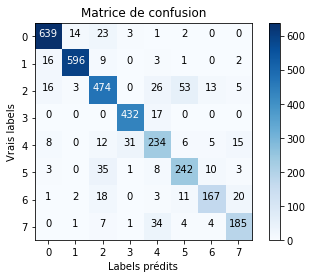

Durée : 965.093 sec


In [72]:
my_CNN_TL(data_df, 60, "equalizer", "ResNet50")

##### Mean Shift

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 01:32:53.642583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.4147 - accuracy: 0.5261

2022-01-19 01:33:35.880270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 50s 144ms/step - loss: 1.4138 - accuracy: 0.5264 - val_loss: 2.5344 - val_accuracy: 0.2492
Epoch 2/30
321/321 [==============================] - 45s 139ms/step - loss: 0.7952 - accuracy: 0.7225 - val_loss: 0.9522 - val_accuracy: 0.6429
Epoch 3/30
321/321 [==============================] - 44s 139ms/step - loss: 0.6428 - accuracy: 0.7655 - val_loss: 3.7905 - val_accuracy: 0.2477
Epoch 4/30
321/321 [==============================] - 44s 138ms/step - loss: 0.5845 - accuracy: 0.7859 - val_loss: 0.9930 - val_accuracy: 0.6593
Epoch 5/30
321/321 [==============================] - 44s 138ms/step - loss: 0.5162 - accuracy: 0.8148 - val_loss: 2.9382 - val_accuracy: 0.3580

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/30
321/321 [==============================] - 45s 139ms/step - loss: 0.3928 - accuracy: 0.8623 - val_loss: 0.4687 - val_accuracy: 0.8266
Epoch 7/30
321/321 [==============================] - 44s 1

2022-01-19 01:41:05.885777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


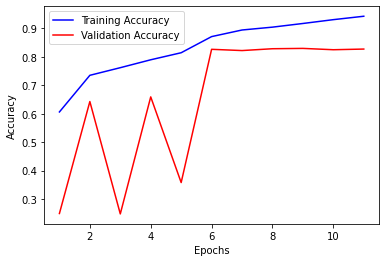

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       682
           1       0.78      0.86      0.82       627
           2       0.75      0.71      0.73       590
           3       0.98      1.00      0.99       449
           4       0.92      0.82      0.87       311
           5       0.72      0.60      0.65       302
           6       0.78      0.83      0.81       222
           7       0.89      0.82      0.86       236

    accuracy                           0.84      3419
   macro avg       0.84      0.83      0.83      3419
weighted avg       0.84      0.84      0.84      3419



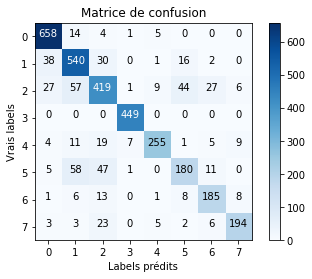

Durée : 517.286 sec


In [8]:
my_CNN_TL(data_df, 60, "mean_shift", "ResNet50")

##### Gray

In [ ]:
my_CNN_TL(data_df, 60, "gray", "ResNet50")

##### LAB

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 11:38:03.731328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.3825 - accuracy: 0.4792

2022-01-19 11:39:02.803394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 71s 191ms/step - loss: 1.3819 - accuracy: 0.4794 - val_loss: 100.0281 - val_accuracy: 0.1354
Epoch 2/30
321/321 [==============================] - 52s 158ms/step - loss: 0.9151 - accuracy: 0.6552 - val_loss: 78.1301 - val_accuracy: 0.0673
Epoch 3/30
321/321 [==============================] - 52s 162ms/step - loss: 0.8721 - accuracy: 0.6681 - val_loss: 23.0169 - val_accuracy: 0.0673
Epoch 4/30
321/321 [==============================] - 51s 159ms/step - loss: 0.7701 - accuracy: 0.7089 - val_loss: 130.8459 - val_accuracy: 0.0933
Epoch 5/30
321/321 [==============================] - 50s 156ms/step - loss: 0.6200 - accuracy: 0.7651 - val_loss: 37.2983 - val_accuracy: 0.0758
Epoch 6/30
321/321 [==============================] - 51s 159ms/step - loss: 0.5482 - accuracy: 0.7941 - val_loss: 48.4545 - val_accuracy: 0.1617

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
321/321 [==============================]

2022-01-19 11:58:24.630815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


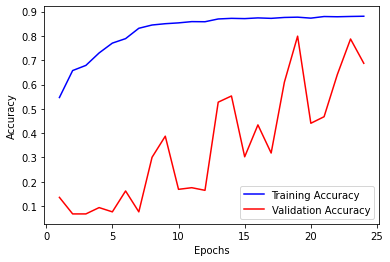

              precision    recall  f1-score   support

           0       0.56      0.99      0.71       667
           1       0.82      0.88      0.85       639
           2       0.42      0.24      0.31       589
           3       0.99      0.96      0.98       449
           4       0.96      0.42      0.59       311
           5       0.87      0.11      0.20       289
           6       0.55      0.93      0.69       222
           7       0.77      0.64      0.70       253

    accuracy                           0.68      3419
   macro avg       0.74      0.65      0.63      3419
weighted avg       0.72      0.68      0.65      3419



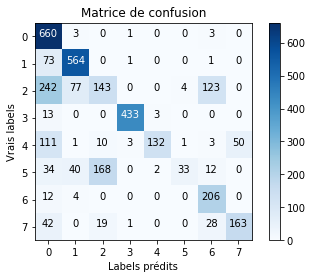

Durée : 1271.32 sec


In [35]:
my_CNN_TL(data_df, 60, "lab", "ResNet50")

##### Canny

In [ ]:
my_CNN_TL(data_df, 60, "canny", "ResNet50")

##### Otsu

In [ ]:
my_CNN_TL(data_df, 60, "otsu", "ResNet50")

##### Otsu_canny

In [ ]:
my_CNN_TL(data_df, 60, "otsu_canny", "ResNet50")

##### Threshold_color --> Gray

In [ ]:
my_CNN_TL(data_df, 60, "threshold_color_g", "ResNet50")

##### Kmeans1

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 08:54:18.762964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.2879 - accuracy: 0.5619

2022-01-19 08:55:02.640762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 53s 148ms/step - loss: 1.2871 - accuracy: 0.5621 - val_loss: 2.4413 - val_accuracy: 0.3249
Epoch 2/30
321/321 [==============================] - 45s 140ms/step - loss: 0.8911 - accuracy: 0.6975 - val_loss: 0.8995 - val_accuracy: 0.6765
Epoch 3/30
321/321 [==============================] - 45s 140ms/step - loss: 0.7457 - accuracy: 0.7285 - val_loss: 0.6894 - val_accuracy: 0.7447
Epoch 4/30
321/321 [==============================] - 45s 140ms/step - loss: 0.6160 - accuracy: 0.7789 - val_loss: 1.3863 - val_accuracy: 0.5297
Epoch 5/30
321/321 [==============================] - 45s 140ms/step - loss: 0.5846 - accuracy: 0.7843 - val_loss: 1.5033 - val_accuracy: 0.5551
Epoch 6/30
321/321 [==============================] - 45s 140ms/step - loss: 0.5365 - accuracy: 0.8015 - val_loss: 0.9011 - val_accuracy: 0.7002

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
321/321 [==============================] - 45s 1

2022-01-19 09:03:22.527836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


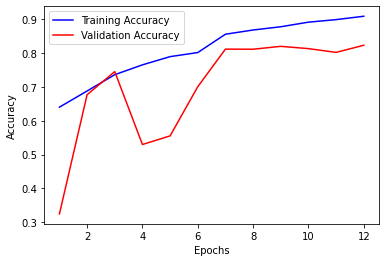

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       667
           1       0.88      0.81      0.84       639
           2       0.74      0.74      0.74       589
           3       0.99      0.99      0.99       449
           4       0.93      0.79      0.85       311
           5       0.65      0.56      0.60       289
           6       0.58      0.87      0.70       222
           7       0.86      0.74      0.79       253

    accuracy                           0.82      3419
   macro avg       0.81      0.80      0.80      3419
weighted avg       0.83      0.82      0.82      3419



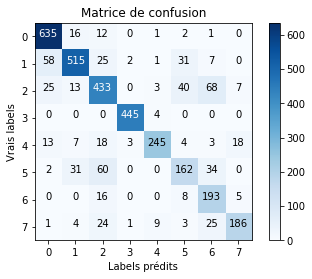

Durée : 571.096 sec


In [20]:
my_CNN_TL(data_df, 60, "kmeans1", "ResNet50")

## TL Xception

##### RGB

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 18:27:38.750786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 0.7969 - accuracy: 0.7438

2022-01-18 18:28:56.713214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 92s 254ms/step - loss: 0.7960 - accuracy: 0.7441 - val_loss: 0.5883 - val_accuracy: 0.8377
Epoch 2/30
321/321 [==============================] - 76s 234ms/step - loss: 0.2122 - accuracy: 0.9266 - val_loss: 0.2144 - val_accuracy: 0.9219
Epoch 3/30
321/321 [==============================] - 75s 232ms/step - loss: 0.1504 - accuracy: 0.9519 - val_loss: 0.2575 - val_accuracy: 0.9386
Epoch 4/30
321/321 [==============================] - 74s 230ms/step - loss: 0.0900 - accuracy: 0.9705 - val_loss: 0.2569 - val_accuracy: 0.9280
Epoch 5/30
321/321 [==============================] - 74s 229ms/step - loss: 0.0832 - accuracy: 0.9765 - val_loss: 0.1816 - val_accuracy: 0.9433
Epoch 6/30
321/321 [==============================] - 74s 230ms/step - loss: 0.0754 - accuracy: 0.9750 - val_loss: 0.6047 - val_accuracy: 0.8617
Epoch 7/30
321/321 [==============================] - 74s 232ms/step - loss: 0.0635 - accuracy: 0.9792 - val_loss: 0.2383 - val_accuracy: 0.9

2022-01-18 18:55:24.579798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


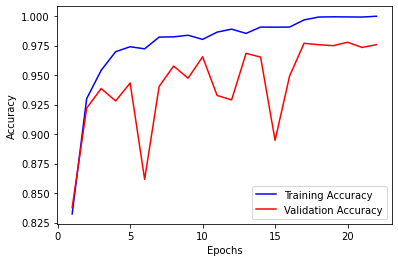

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       667
           1       1.00      1.00      1.00       639
           2       0.95      0.93      0.94       589
           3       1.00      1.00      1.00       449
           4       0.97      0.97      0.97       311
           5       0.95      0.96      0.95       289
           6       0.97      0.98      0.97       222
           7       0.98      0.98      0.98       253

    accuracy                           0.97      3419
   macro avg       0.97      0.97      0.97      3419
weighted avg       0.97      0.97      0.97      3419



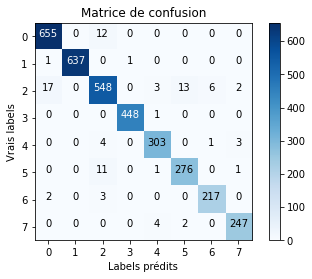

Durée : 1700.519 sec


In [48]:
my_CNN_TL(data_df, 60, "rgb", "Xception")

##### HSV

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 20:00:47.591935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 0.9702 - accuracy: 0.6615

2022-01-18 20:02:04.856186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 89s 262ms/step - loss: 0.9692 - accuracy: 0.6618 - val_loss: 0.8647 - val_accuracy: 0.7602
Epoch 2/30
321/321 [==============================] - 75s 233ms/step - loss: 0.3186 - accuracy: 0.8940 - val_loss: 0.4525 - val_accuracy: 0.8666
Epoch 3/30
321/321 [==============================] - 75s 232ms/step - loss: 0.2112 - accuracy: 0.9322 - val_loss: 0.4828 - val_accuracy: 0.8581
Epoch 4/30
321/321 [==============================] - 74s 231ms/step - loss: 0.1617 - accuracy: 0.9451 - val_loss: 0.4512 - val_accuracy: 0.8827
Epoch 5/30
321/321 [==============================] - 74s 231ms/step - loss: 0.0997 - accuracy: 0.9675 - val_loss: 0.2172 - val_accuracy: 0.9359
Epoch 6/30
321/321 [==============================] - 75s 233ms/step - loss: 0.0902 - accuracy: 0.9717 - val_loss: 0.3300 - val_accuracy: 0.9087
Epoch 7/30
321/321 [==============================] - 75s 234ms/step - loss: 0.0631 - accuracy: 0.9780 - val_loss: 0.2445 - val_accuracy: 0.9

2022-01-18 20:18:25.291153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


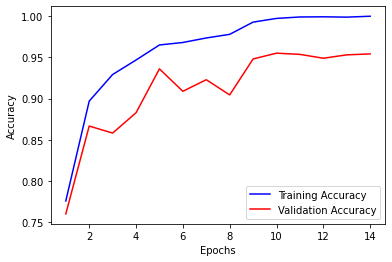

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       667
           1       0.99      0.98      0.98       639
           2       0.90      0.91      0.90       589
           3       1.00      1.00      1.00       449
           4       0.97      0.96      0.96       311
           5       0.91      0.89      0.90       289
           6       0.90      0.89      0.90       222
           7       0.96      0.97      0.96       253

    accuracy                           0.95      3419
   macro avg       0.95      0.95      0.95      3419
weighted avg       0.95      0.95      0.95      3419



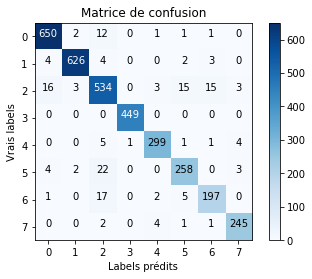

Durée : 1091.921 sec


In [53]:
my_CNN_TL(data_df, 60, "hsv", "Xception")

##### Threshold color

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 21:04:45.880880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.0083 - accuracy: 0.6489

2022-01-18 21:06:02.410827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 91s 252ms/step - loss: 1.0073 - accuracy: 0.6492 - val_loss: 1.0620 - val_accuracy: 0.6394
Epoch 2/30
321/321 [==============================] - 77s 235ms/step - loss: 0.3461 - accuracy: 0.8769 - val_loss: 0.3504 - val_accuracy: 0.8807
Epoch 3/30
321/321 [==============================] - 75s 235ms/step - loss: 0.2428 - accuracy: 0.9192 - val_loss: 0.3277 - val_accuracy: 0.8970
Epoch 4/30
321/321 [==============================] - 74s 231ms/step - loss: 0.1854 - accuracy: 0.9390 - val_loss: 0.5731 - val_accuracy: 0.8523
Epoch 5/30
321/321 [==============================] - 75s 234ms/step - loss: 0.1424 - accuracy: 0.9527 - val_loss: 0.4302 - val_accuracy: 0.8766
Epoch 6/30
321/321 [==============================] - 75s 234ms/step - loss: 0.1003 - accuracy: 0.9697 - val_loss: 0.6379 - val_accuracy: 0.8517

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
321/321 [==============================] - 75s 2

2022-01-18 21:19:56.853973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


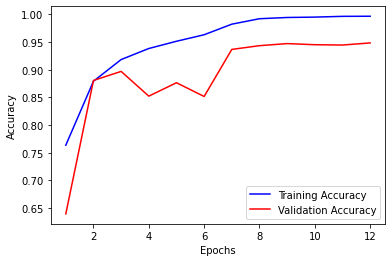

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       667
           1       0.98      0.97      0.98       639
           2       0.89      0.92      0.91       589
           3       1.00      1.00      1.00       449
           4       0.97      0.97      0.97       311
           5       0.90      0.93      0.91       289
           6       0.98      0.91      0.94       222
           7       0.97      0.96      0.96       253

    accuracy                           0.96      3419
   macro avg       0.96      0.95      0.95      3419
weighted avg       0.96      0.96      0.96      3419



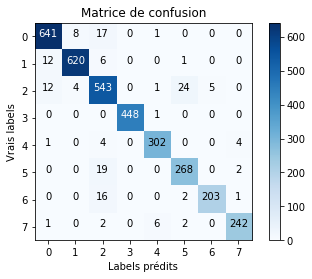

Durée : 944.26 sec


In [58]:
my_CNN_TL(data_df, 60, "threshold_color", "Xception")

##### Kmeans2

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 22:11:20.289607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.0678 - accuracy: 0.6482

2022-01-18 22:12:39.302311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 93s 260ms/step - loss: 1.0666 - accuracy: 0.6486 - val_loss: 0.4720 - val_accuracy: 0.8350
Epoch 2/30
321/321 [==============================] - 78s 238ms/step - loss: 0.3557 - accuracy: 0.8835 - val_loss: 0.4165 - val_accuracy: 0.8508
Epoch 3/30
321/321 [==============================] - 75s 232ms/step - loss: 0.2602 - accuracy: 0.9129 - val_loss: 0.3396 - val_accuracy: 0.8894
Epoch 4/30
321/321 [==============================] - 75s 232ms/step - loss: 0.1873 - accuracy: 0.9376 - val_loss: 0.3826 - val_accuracy: 0.8713
Epoch 5/30
321/321 [==============================] - 75s 232ms/step - loss: 0.1497 - accuracy: 0.9509 - val_loss: 0.2785 - val_accuracy: 0.9099
Epoch 6/30
321/321 [==============================] - 77s 239ms/step - loss: 0.1341 - accuracy: 0.9568 - val_loss: 0.5526 - val_accuracy: 0.8377
Epoch 7/30
321/321 [==============================] - 76s 237ms/step - loss: 0.1200 - accuracy: 0.9590 - val_loss: 0.3272 - val_accuracy: 0.8

2022-01-18 22:29:28.412437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


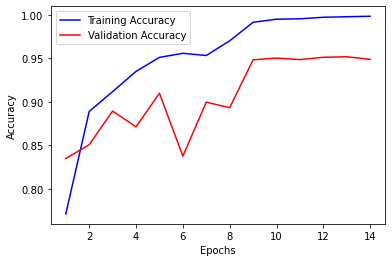

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       667
           1       0.96      0.99      0.97       639
           2       0.87      0.90      0.88       589
           3       1.00      1.00      1.00       449
           4       0.94      0.93      0.94       311
           5       0.95      0.83      0.89       289
           6       0.90      0.93      0.92       222
           7       0.96      0.91      0.93       253

    accuracy                           0.94      3419
   macro avg       0.94      0.93      0.94      3419
weighted avg       0.94      0.94      0.94      3419



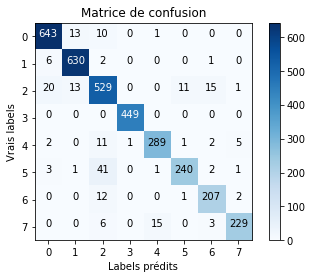

Durée : 1122.558 sec


In [63]:
my_CNN_TL(data_df, 60, "kmeans2", "Xception")

##### KmeansXYRGB

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-18 23:35:15.765284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.0473 - accuracy: 0.6303

2022-01-18 23:36:38.277535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 95s 268ms/step - loss: 1.0463 - accuracy: 0.6307 - val_loss: 1.1730 - val_accuracy: 0.7014
Epoch 2/30
321/321 [==============================] - 80s 248ms/step - loss: 0.4152 - accuracy: 0.8547 - val_loss: 0.4134 - val_accuracy: 0.8590
Epoch 3/30
321/321 [==============================] - 76s 237ms/step - loss: 0.2828 - accuracy: 0.9043 - val_loss: 0.4973 - val_accuracy: 0.8608
Epoch 4/30
321/321 [==============================] - 76s 236ms/step - loss: 0.2277 - accuracy: 0.9206 - val_loss: 0.6436 - val_accuracy: 0.8078
Epoch 5/30
321/321 [==============================] - 76s 236ms/step - loss: 0.1788 - accuracy: 0.9375 - val_loss: 0.2897 - val_accuracy: 0.9032
Epoch 6/30
321/321 [==============================] - 76s 236ms/step - loss: 0.1529 - accuracy: 0.9490 - val_loss: 0.3626 - val_accuracy: 0.8883
Epoch 7/30
321/321 [==============================] - 76s 236ms/step - loss: 0.1246 - accuracy: 0.9583 - val_loss: 0.6176 - val_accuracy: 0.8

2022-01-18 23:53:21.490261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


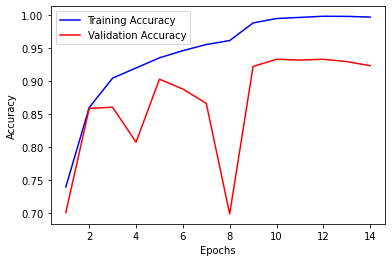

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       682
           1       0.99      0.98      0.99       627
           2       0.79      0.90      0.84       590
           3       0.99      1.00      1.00       449
           4       0.99      0.89      0.94       311
           5       0.88      0.83      0.85       302
           6       0.93      0.88      0.90       222
           7       0.89      0.83      0.86       236

    accuracy                           0.93      3419
   macro avg       0.93      0.91      0.92      3419
weighted avg       0.93      0.93      0.93      3419



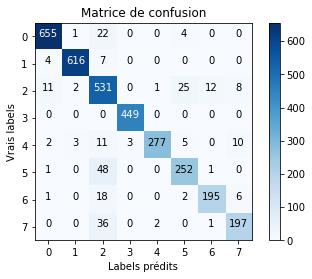

Durée : 1148.118 sec


In [68]:
my_CNN_TL(data_df, 60, "kmeansXYRGB", "Xception")

##### Equalizer

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 00:27:04.023280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.4287 - accuracy: 0.4586

2022-01-19 00:28:32.133386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 105s 290ms/step - loss: 1.4272 - accuracy: 0.4592 - val_loss: 1.2876 - val_accuracy: 0.6873
Epoch 2/30
321/321 [==============================] - 86s 267ms/step - loss: 0.3742 - accuracy: 0.8802 - val_loss: 0.4524 - val_accuracy: 0.8643
Epoch 3/30
321/321 [==============================] - 82s 256ms/step - loss: 0.2444 - accuracy: 0.9178 - val_loss: 0.3151 - val_accuracy: 0.8953
Epoch 4/30
321/321 [==============================] - 86s 263ms/step - loss: 0.1529 - accuracy: 0.9519 - val_loss: 0.4381 - val_accuracy: 0.8880
Epoch 5/30
321/321 [==============================] - 78s 242ms/step - loss: 0.1183 - accuracy: 0.9615 - val_loss: 0.4240 - val_accuracy: 0.8757
Epoch 6/30
321/321 [==============================] - 78s 242ms/step - loss: 0.1098 - accuracy: 0.9682 - val_loss: 1.1434 - val_accuracy: 0.8836

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
321/321 [==============================] - 82s 

2022-01-19 00:43:35.566372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


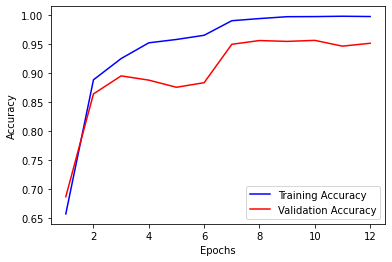

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       682
           1       0.99      1.00      0.99       627
           2       0.95      0.90      0.92       590
           3       0.98      0.99      0.99       449
           4       0.94      0.91      0.92       311
           5       0.91      0.92      0.91       302
           6       0.90      0.94      0.92       222
           7       0.95      0.96      0.96       236

    accuracy                           0.96      3419
   macro avg       0.95      0.95      0.95      3419
weighted avg       0.96      0.96      0.96      3419



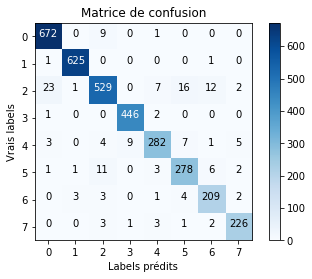

Durée : 1051.786 sec


In [73]:
my_CNN_TL(data_df, 60, "equalizer", "Xception")

##### Mean Shift

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 01:41:31.181956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.4300 - accuracy: 0.4631

2022-01-19 01:42:36.603021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 75s 222ms/step - loss: 1.4286 - accuracy: 0.4637 - val_loss: 0.9556 - val_accuracy: 0.6868
Epoch 2/30
321/321 [==============================] - 70s 216ms/step - loss: 0.4983 - accuracy: 0.8270 - val_loss: 0.7248 - val_accuracy: 0.7593
Epoch 3/30
321/321 [==============================] - 69s 214ms/step - loss: 0.3709 - accuracy: 0.8674 - val_loss: 0.6477 - val_accuracy: 0.7742
Epoch 4/30
321/321 [==============================] - 69s 214ms/step - loss: 0.3003 - accuracy: 0.8991 - val_loss: 0.5930 - val_accuracy: 0.8166
Epoch 5/30
321/321 [==============================] - 69s 215ms/step - loss: 0.2362 - accuracy: 0.9184 - val_loss: 1.1681 - val_accuracy: 0.7596
Epoch 6/30
321/321 [==============================] - 69s 214ms/step - loss: 0.2039 - accuracy: 0.9346 - val_loss: 0.5747 - val_accuracy: 0.8590
Epoch 7/30
321/321 [==============================] - 69s 214ms/step - loss: 0.1785 - accuracy: 0.9416 - val_loss: 0.5885 - val_accuracy: 0.8

2022-01-19 02:05:42.909312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


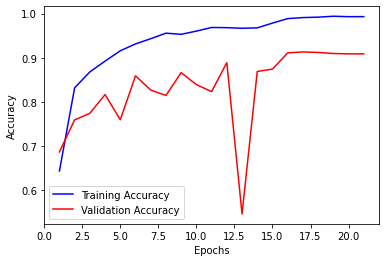

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       682
           1       0.95      0.96      0.96       627
           2       0.80      0.85      0.82       590
           3       1.00      1.00      1.00       449
           4       0.95      0.95      0.95       311
           5       0.84      0.70      0.76       302
           6       0.82      0.94      0.87       222
           7       0.95      0.83      0.88       236

    accuracy                           0.91      3419
   macro avg       0.91      0.90      0.90      3419
weighted avg       0.91      0.91      0.91      3419



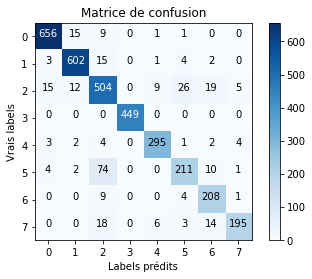

Durée : 1479.241 sec


In [9]:
my_CNN_TL(data_df, 60, "mean_shift", "Xception")

##### Gray

In [ ]:
my_CNN_TL(data_df, 60, "gray", "Xception")

##### LAB

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 10:06:19.959531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.0276 - accuracy: 0.6543

2022-01-19 10:07:33.964913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 89s 247ms/step - loss: 1.0264 - accuracy: 0.6547 - val_loss: 0.4433 - val_accuracy: 0.8833
Epoch 2/30
321/321 [==============================] - 75s 231ms/step - loss: 0.2740 - accuracy: 0.9162 - val_loss: 0.5279 - val_accuracy: 0.8409
Epoch 3/30
321/321 [==============================] - 74s 231ms/step - loss: 0.1587 - accuracy: 0.9467 - val_loss: 0.4529 - val_accuracy: 0.8652
Epoch 4/30
321/321 [==============================] - 73s 227ms/step - loss: 0.1366 - accuracy: 0.9537 - val_loss: 0.1985 - val_accuracy: 0.9342
Epoch 5/30
321/321 [==============================] - 74s 231ms/step - loss: 0.0922 - accuracy: 0.9702 - val_loss: 0.4817 - val_accuracy: 0.9073
Epoch 6/30
321/321 [==============================] - 74s 229ms/step - loss: 0.0865 - accuracy: 0.9730 - val_loss: 0.3868 - val_accuracy: 0.8953
Epoch 7/30
321/321 [==============================] - 74s 229ms/step - loss: 0.0792 - accuracy: 0.9737 - val_loss: 0.2956 - val_accuracy: 0.9

2022-01-19 10:22:27.120654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


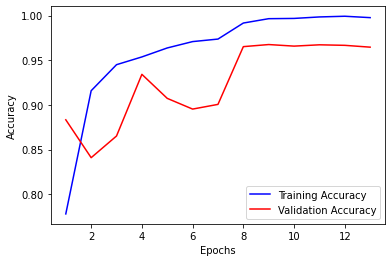

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       667
           1       1.00      0.99      1.00       639
           2       0.91      0.95      0.93       589
           3       1.00      1.00      1.00       449
           4       0.99      0.90      0.94       311
           5       0.93      0.95      0.94       289
           6       0.99      0.92      0.96       222
           7       0.92      0.98      0.95       253

    accuracy                           0.96      3419
   macro avg       0.96      0.96      0.96      3419
weighted avg       0.97      0.96      0.96      3419



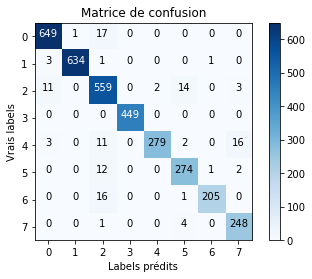

Durée : 1004.922 sec


In [26]:
my_CNN_TL(data_df, 60, "lab", "Xception")

##### Canny

In [ ]:
my_CNN_TL(data_df, 60, "canny", "Xception")

##### Otsu

In [ ]:
my_CNN_TL(data_df, 60, "otsu", "Xception")

##### Otsu_canny

In [ ]:
my_CNN_TL(data_df, 60, "otsu_canny", "Xception")

##### Threshold_color --> Gray

In [ ]:
my_CNN_TL(data_df, 60, "threshold_color_g", "Xception")

##### Kmeans1

X_train: 10254 
X_valid: 3419 
X_test: 3419 

Epoch 1/30


2022-01-19 09:03:51.105376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 1.1437 - accuracy: 0.6116

2022-01-19 09:04:57.412454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 77s 224ms/step - loss: 1.1427 - accuracy: 0.6119 - val_loss: 0.5550 - val_accuracy: 0.7926
Epoch 2/30
321/321 [==============================] - 70s 217ms/step - loss: 0.5301 - accuracy: 0.8226 - val_loss: 1.1559 - val_accuracy: 0.7192
Epoch 3/30
321/321 [==============================] - 70s 218ms/step - loss: 0.3498 - accuracy: 0.8858 - val_loss: 0.5081 - val_accuracy: 0.8429
Epoch 4/30
321/321 [==============================] - 70s 219ms/step - loss: 0.2734 - accuracy: 0.9140 - val_loss: 0.4634 - val_accuracy: 0.8505
Epoch 5/30
321/321 [==============================] - 70s 217ms/step - loss: 0.2117 - accuracy: 0.9248 - val_loss: 0.4059 - val_accuracy: 0.8754
Epoch 6/30
321/321 [==============================] - 70s 218ms/step - loss: 0.1435 - accuracy: 0.9504 - val_loss: 0.6553 - val_accuracy: 0.8309
Epoch 7/30
321/321 [==============================] - 70s 218ms/step - loss: 0.1375 - accuracy: 0.9546 - val_loss: 1.0587 - val_accuracy: 0.7

2022-01-19 09:20:13.997951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


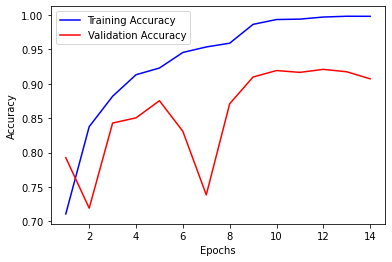

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       667
           1       0.99      0.92      0.95       639
           2       0.76      0.88      0.82       589
           3       1.00      1.00      1.00       449
           4       0.96      0.96      0.96       311
           5       0.86      0.64      0.73       289
           6       0.86      0.86      0.86       222
           7       0.96      0.88      0.92       253

    accuracy                           0.90      3419
   macro avg       0.91      0.89      0.90      3419
weighted avg       0.91      0.90      0.90      3419



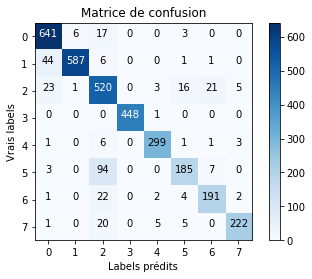

Durée : 1012.084 sec


In [21]:
my_CNN_TL(data_df, 60, "kmeans1", "Xception")